# Readme
This notebook is a "fair" copy of all the code that I have used in the SCTLD work. All analysis performed here will result in the same results as mentioned in the publication. 


### Packages Used with version description

In [5]:
# import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import sys
import pandas as pd

print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("python version:", sys.version)

import skbio
print("scikit-bio version:", skbio.__version__)

from skbio.diversity import alpha

import scipy
print("SciPy version:", scipy.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

import pydeseq2
print("pyDESeq2 version:", pydeseq2.__version__)

pandas version: 2.2.3
matplotlib version: 3.6.2
numpy version: 1.26.4
seaborn version: 0.13.2
python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
scikit-bio version: 0.6.3
SciPy version: 1.13.1
scikit-learn version: 1.6.1
pyDESeq2 version: 0.4.8


# 1. Diversity Metrics

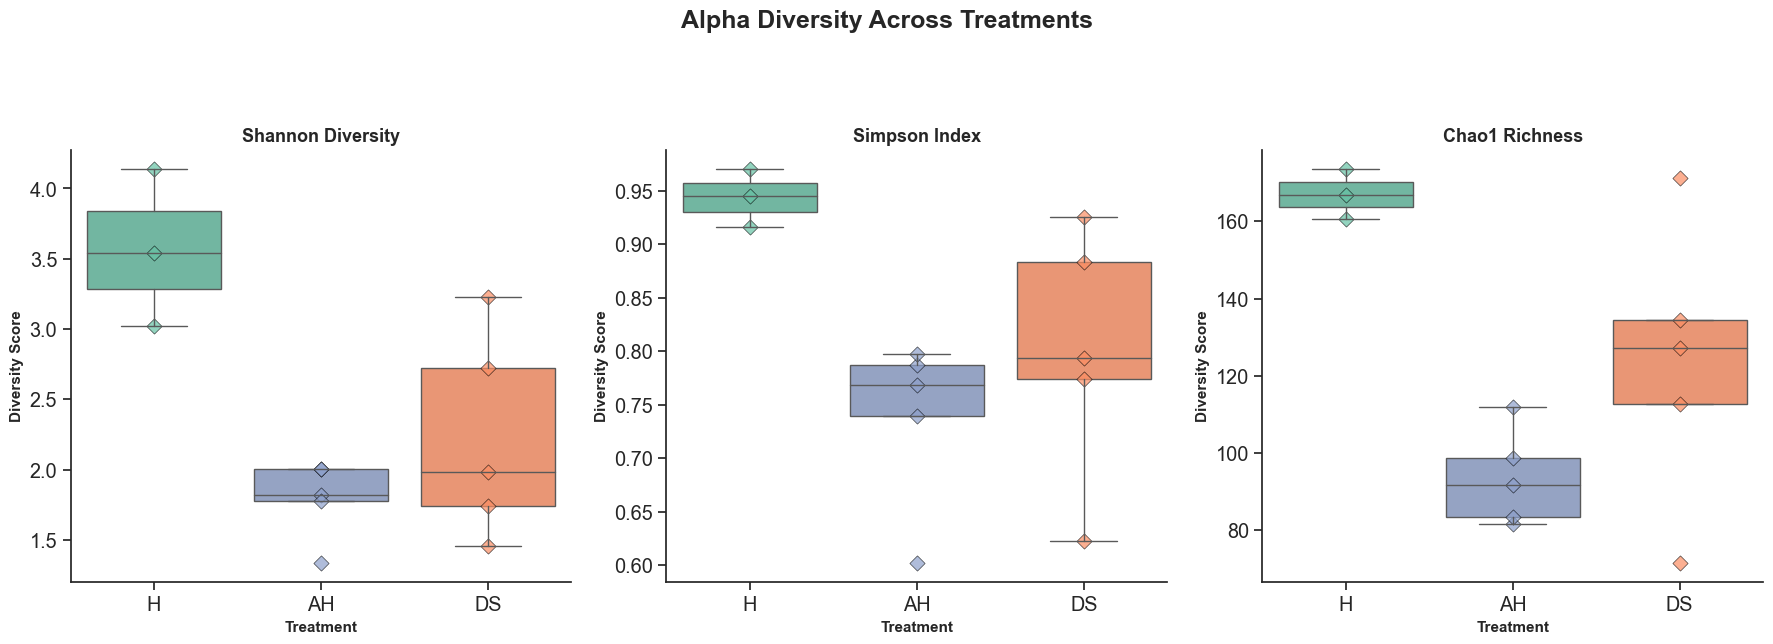

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.diversity.alpha import shannon, simpson, chao1

# -------------------- Data Preparation --------------------
# Load and filter
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")
df = df[df.index != "unmapped"]
df = df.filter(like="TPM_")
df.columns = df.columns.str.replace("TPM_", "", regex=True)

# Transpose and merge metadata
df = df.transpose().reset_index().rename(columns={"index": "Sample"})
metadata = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/SCTLD_metadata.csv')
df = pd.merge(df, metadata, on="Sample")

# Drop unnecessary metadata columns
df = df.drop(columns=["Sample Name", "Project", "Colony", "Location", "Species", "Porject"], errors="ignore")
df.rename(columns={"Health": "Treatment"}, inplace=True)
df = df[~df['Sample'].isin(['N31', 'N37'])]

# Convert MAGs to numeric
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].apply(pd.to_numeric, errors="coerce").astype(int)
df.dropna(inplace=True)

# -------------------- Diversity Calculation --------------------
mag_counts = df.iloc[:, 1:-1]
df["Shannon"] = mag_counts.apply(shannon, axis=1)
df["Simpson"] = mag_counts.apply(simpson, axis=1)
df["Chao1"] = mag_counts.apply(chao1, axis=1)

# Replace infs and drop them
df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
df.dropna(subset=["Shannon", "Simpson", "Chao1"], inplace=True)

# Melt for plotting
df_melted = df.melt(
    id_vars=["Sample", "Treatment"],
    value_vars=["Shannon", "Simpson", "Chao1"],
    var_name="Metric", value_name="Diversity Score"
)

# -------------------- Plotting --------------------
custom_palette = {
    "H": "#66c2a5",     # green
    "AH": "#8da0cb",    # blue
    "DS": "#fc8d62"     # orange
}

treatment_order = ["H", "AH", "DS"]
metric_titles = ["Shannon Diversity", "Simpson Index", "Chao1 Richness"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(["Shannon", "Simpson", "Chao1"]):
    ax = axes[i]
    data = df_melted[df_melted["Metric"] == metric]

    # Boxplot
    sns.boxplot(
        data=data,
        x="Treatment", y="Diversity Score",
        palette=custom_palette,
        showfliers=False,
        linewidth=1,
        order=treatment_order,
        ax=ax
    )

    # Manual "stripplot" with diamond markers
    for j, treatment in enumerate(treatment_order):
        y_vals = data[data["Treatment"] == treatment]["Diversity Score"]
        x_vals = [j] * len(y_vals)
        ax.scatter(
            x_vals,
            y_vals,
            marker="D",
            s=60,
            alpha=0.7,
            color=custom_palette[treatment],
            edgecolor="black",
            linewidth=0.5
        )

    ax.set_title(metric_titles[i], fontsize=13, fontweight="bold")
    ax.set_xlabel("Treatment", fontsize=11, fontweight="bold")
    ax.set_ylabel("Diversity Score", fontsize=11, fontweight="bold")
    ax.grid(False)
    sns.despine(ax=ax)

    # Remove any legends that sneak in
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# No global legend
plt.suptitle("Alpha Diversity Across Treatments", fontsize=18, fontweight="bold", y=1.08)
plt.tight_layout()
plt.savefig("/Users/Shrini/Desktop/alpha_diversity_final_nolegend.pdf", bbox_inches='tight')
plt.show()



# 1b. Beta Diversity

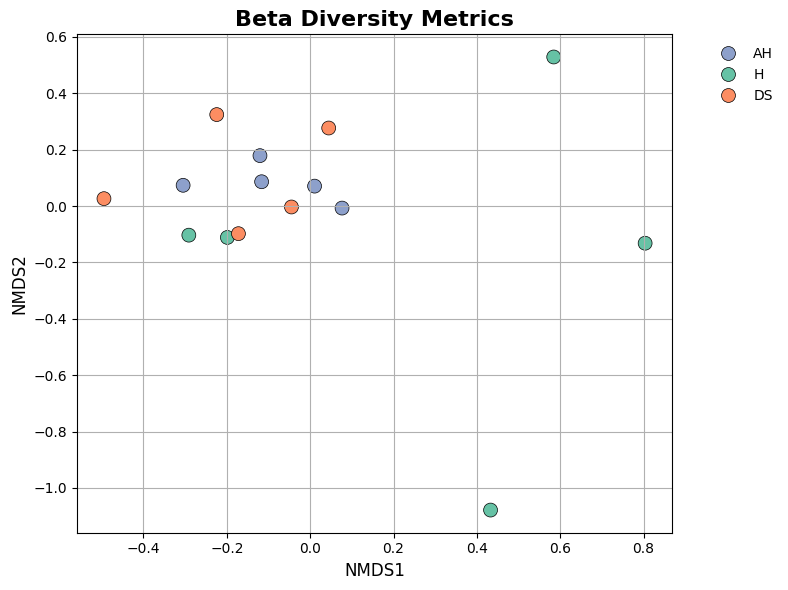

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from skbio.stats.composition import clr

# -------------------- Data Setup --------------------
# Load counts
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")
df = df[df.index != "unmapped"]
df = df.filter(like="Read Count_")
df = df + 1  # pseudocount to avoid log(0)

# CLR + Aitchison Distance
transposed_df = df.transpose()
clr_data = clr(transposed_df.values)
aitchison_matrix = squareform(pdist(clr_data, metric='euclidean'))
aitchison_df = pd.DataFrame(aitchison_matrix, index=transposed_df.index, columns=transposed_df.index)
aitchison_df.index = aitchison_df.index.str.replace("Read Count_", "", regex=False)
aitchison_df.columns = aitchison_df.columns.str.replace("Read Count_", "", regex=False)

# -------------------- NMDS --------------------
nmds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, metric=False)
nmds_result = nmds.fit_transform(aitchison_df)

nmds_df = pd.DataFrame(nmds_result, columns=["NMDS1", "NMDS2"], index=aitchison_df.index)

# Metadata merge
metadata = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/SCTLD_metadata.csv')
metadata = metadata.set_index("Sample")
nmds_metadata_df = nmds_df.merge(metadata, left_index=True, right_index=True)

# -------------------- Plot --------------------
# Color map for legend (matches original plot)
treatment_colors = {
    "H": "#66c2a5",            # green
    "AH": "#8da0cb", # blue
    "DS": "#fc8d62"            # orange
}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="NMDS1", y="NMDS2",
    hue="Health",  # assumes this column contains "Healthy", "Apparently Healthy", etc.
    data=nmds_metadata_df,
    palette=treatment_colors,
    s=100,
    edgecolor="black",
    linewidth=0.5
)

plt.title("Beta Diversity Metrics", fontsize=16, fontweight="bold")
plt.xlabel("NMDS1", fontsize=12)
plt.ylabel("NMDS2", fontsize=12)
plt.grid(True)
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
#plt.savefig('/Users/Shrini/Desktop/desktop_SCTLD_Complete/Output/SCTLD_Manuscript_v2/Figures/NMDS_cleaned_and_updated.pdf', bbox_inches='tight')
plt.show()


### permdisp code 
'''
# -------------------- Metadata Merge --------------------
metadata = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/SCTLD_metadata.csv')
metadata = metadata.set_index("Sample")

# Align metadata to NMDS and distance matrix
metadata_filtered = metadata.loc[transposed_df.index]
assert all(metadata_filtered.index == transposed_df.index), "Mismatch between metadata and CLR matrix IDs."
nmds_metadata_df = nmds_df.merge(metadata_filtered, left_index=True, right_index=True)

# -------------------- PERMANOVA + PERMDISP --------------------
distance_matrix = DistanceMatrix(aitchison_matrix, ids=transposed_df.index)
grouping = metadata_filtered["Health"]

permanova_result = permanova(distance_matrix, grouping, permutations=999)
permdisp_result = permdisp(distance_matrix, grouping)

print("PERMANOVA result:")
print(permanova_result)

print("\nPERMDISP result:")
print(permdisp_result)
'''



PERMANOVA result:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      15
number of groups                  3
test statistic             0.957319
p-value                       0.584
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMDISP result:
method name               PERMDISP
test statistic name        F-value
sample size                     15
number of groups                 3
test statistic            3.733497
p-value                      0.051
number of permutations         999
Name: PERMDISP results, dtype: object


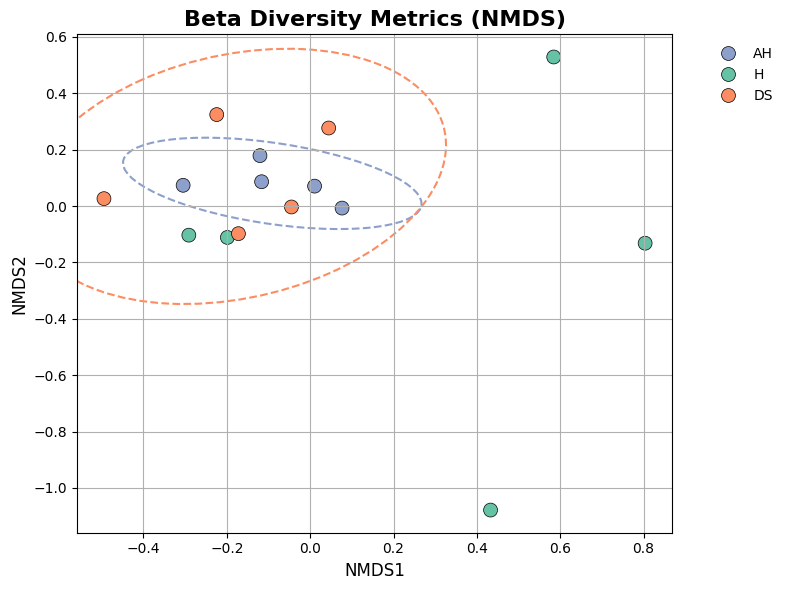

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from skbio.stats.composition import clr
from skbio.stats.distance import DistanceMatrix, permanova, permdisp
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# -------------------- Data Setup --------------------
# Load counts
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")
df = df[df.index != "unmapped"]
df = df.filter(like="Read Count_")
df.columns = df.columns.str.replace("Read Count_", "", regex=False)

# Drop N31 and N37
df = df + 1  # pseudocount to avoid log(0)

# CLR + Aitchison Distance
transposed_df = df.transpose()
clr_data = clr(transposed_df.values)
aitchison_matrix = squareform(pdist(clr_data, metric='euclidean'))
aitchison_df = pd.DataFrame(aitchison_matrix, index=transposed_df.index, columns=transposed_df.index)

# -------------------- NMDS --------------------
nmds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, metric=False)
nmds_result = nmds.fit_transform(aitchison_df)
nmds_df = pd.DataFrame(nmds_result, columns=["NMDS1", "NMDS2"], index=aitchison_df.index)





In [3]:
metadata

,Sample Name,Porject,Colony,Location,Species,Health
Sample,,,,,,
N23,DLABBHC5AH,SCTLD,C5,Palyita Bajahibe,Diploria lab,AH
N24,DLABBHC3H,SCTLD,C3,Palyita Bajahibe,Diploria lab,H
N25,DLABBHC3DS,SCTLD,C3,Palyita Bajahibe,Diploria lab,DS
N26,DLABBHC4DS,SCTLD,C4,Palyita Bajahibe,Diploria lab,DS
N27,DLABBHC5DS,SCTLD,C5,Palyita Bajahibe,Diploria lab,DS
N28,DLABBHC4AH,SCTLD,C4,Palyita Bajahibe,Diploria lab,AH
N29,DLABBHC2DS,SCTLD,C2,Palyita Bajahibe,Diploria lab,DS
N30,DLABBHC3AH,SCTLD,C3,Palyita Bajahibe,Diploria lab,AH
N32,DLABBHC5H,SCTLD,C5,Palyita Bajahibe,Diploria lab,H


# 2. Prokaryote Analysis

## a) Relative Abundance

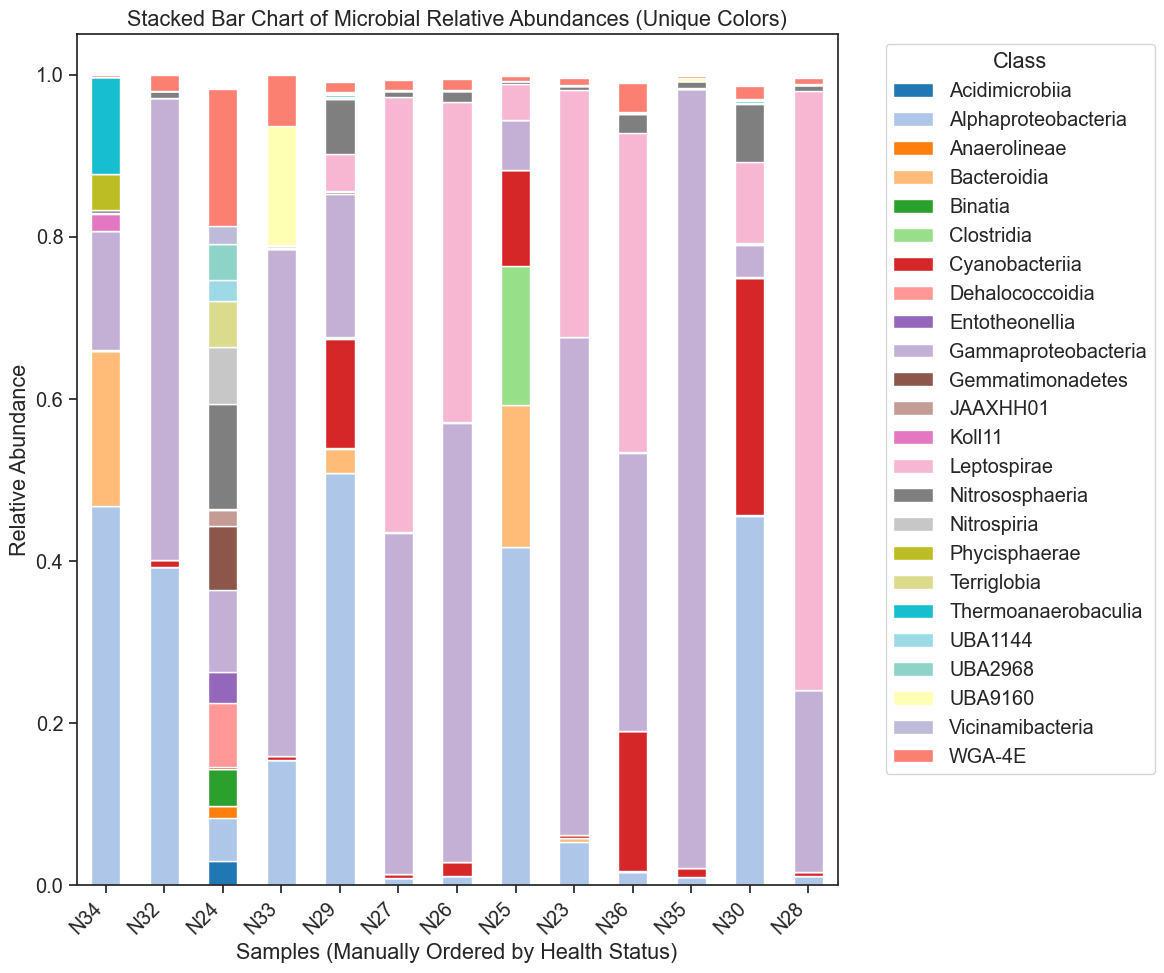

,Phylum,Comparison,U-Statistic,P-value,Group1,Group2,Median_Group1,Median_Group2,Direction,Adjusted P-value
8,Anaerolineae,DS vs AH,23.0,0.034454,Diseased (DS),AH,0.000050,0.000000,Down,0.515089
39,Leptospirae,H vs DS,0.0,0.035714,Healthy (H),Diseased (DS),0.000127,0.045344,Up,0.515089
40,Leptospirae,H vs AH,0.0,0.035714,Healthy (H),AH,0.000127,0.304739,Up,0.515089
46,Nitrospiria,H vs AH,15.0,0.035770,Healthy (H),AH,0.000090,0.000007,Down,0.515089
47,Nitrospiria,DS vs AH,25.0,0.011925,Diseased (DS),AH,0.000120,0.000007,Down,0.515089


In [26]:
# repeat but for phylum
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")
df = df.loc[~df.index.str.contains("MAG_viral_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_plasmid_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_eukaryotic_", regex=False), :]
df = df[df.index != "unmapped"]
df = df.filter(like="TPM_")

#generate relative abundances
# Compute relative abundances
df_relative = df.div(df.sum(axis=0), axis=1) # divide each columns value based on the sum of the column

# Rename columns to include 'RA_' prefix
df_relative = df_relative.add_prefix('RA_')

# Merge with the original dataframe


gtdb = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/gtdb_taxonomy.tsv', sep='\t')
gtdb = gtdb.set_index("MAG")

df_relative_taxa = pd.merge(df_relative, gtdb, left_index=True, right_index=True)
df_relative_taxa.columns = df_relative_taxa.columns.str.replace("RA_TPM_", "", regex=False)

manual_order = [ "N34", "N32", "N24",  # Healthy (H)
                "N33", "N29", "N27", "N26", "N25",  # Diseased (DS)
                "N23", "N36", "N35", "N30", "N28"]  # AH

# Extract numeric data (samples)
numeric_df = df_relative_taxa.select_dtypes(include=["number"])

# Extract 'class' column for grouping
metadata_class = df_relative_taxa["class"]

# Group by 'class'
grouped_df = numeric_df.groupby(metadata_class).sum()

# Transpose for plotting
grouped_df = grouped_df.T

# Manually reorder the samples
grouped_df = grouped_df.loc[manual_order]

# Generate unique colors for up to 24 classes
num_classes = len(grouped_df.columns)
color_palette = sns.color_palette("tab20", min(num_classes, 20)) + sns.color_palette("Set3", max(0, num_classes - 20))

# Plot stacked bar chart with unique colors
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(12, 10), color=color_palette)

# Formatting
plt.xlabel("Samples (Manually Ordered by Health Status)")
plt.ylabel("Relative Abundance")
plt.title("Stacked Bar Chart of Microbial Relative Abundances (Unique Colors)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
#plt.savefig('/Users/Shrini/Desktop/desktop_SCTLD_Complete/Images/phylum_prokaryote_distribution.pdf')
plt.show()


# Convert to DataFrame and adjust p-values for multiple testing
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Define sample groups
h_samples = ["N34", "N32", "N24"]  # Healthy (H)
ds_samples = ["N33", "N29", "N27", "N26", "N25"]  # Diseased (DS)
ah_samples = ["N23", "N36", "N35", "N30", "N28"]  # AH

# Extract numerical data and group by phylum
numeric_df = df_relative_taxa.select_dtypes(include=["number"])
grouped_df = numeric_df.groupby(df_relative_taxa["class"]).sum().T

# Statistical tests
pairwise_results_with_groups = []
phylum_pvals = {}
pairwise_results_with_medians = []

for phylum in grouped_df.columns:
    h_vals = grouped_df.loc[h_samples, phylum]
    ds_vals = grouped_df.loc[ds_samples, phylum]
    ah_vals = grouped_df.loc[ah_samples, phylum]

    # Kruskal-Wallis test across all groups
    stat, pval = kruskal(h_vals, ds_vals, ah_vals)
    phylum_pvals[phylum] = pval

    # Mann-Whitney U tests
    for (group1, group2, label, group1_name, group2_name) in [
        (h_vals, ds_vals, "H vs DS", "Healthy (H)", "Diseased (DS)"),
        (h_vals, ah_vals, "H vs AH", "Healthy (H)", "AH"),
        (ds_vals, ah_vals, "DS vs AH", "Diseased (DS)", "AH")
    ]:
        stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
        median1, median2 = np.median(group1), np.median(group2)
        direction = "Up" if median1 < median2 else "Down"
        pairwise_results_with_medians.append([phylum, label, stat, pval, group1_name, group2_name, median1, median2, direction])

# Convert results to a dataframe
pairwise_df_with_medians = pd.DataFrame(pairwise_results_with_medians,
                                        columns=["Phylum", "Comparison", "U-Statistic", "P-value",
                                                 "Group1", "Group2", "Median_Group1", "Median_Group2", "Direction"])

# Adjust p-values for multiple testing
pairwise_df_with_medians["Adjusted P-value"] = multipletests(pairwise_df_with_medians["P-value"], method="fdr_bh")[1]

# Filter significant results
#significant_pairwise_df_with_medians = pairwise_df_with_medians[pairwise_df_with_medians["Adjusted P-value"] < 0.05]
significant_pairwise_df_with_medians = pairwise_df_with_medians[pairwise_df_with_medians["P-value"] < 0.05]

significant_pairwise_df_with_medians
#pairwise_df_with_medians

# b) Individual MAG lollipop plot

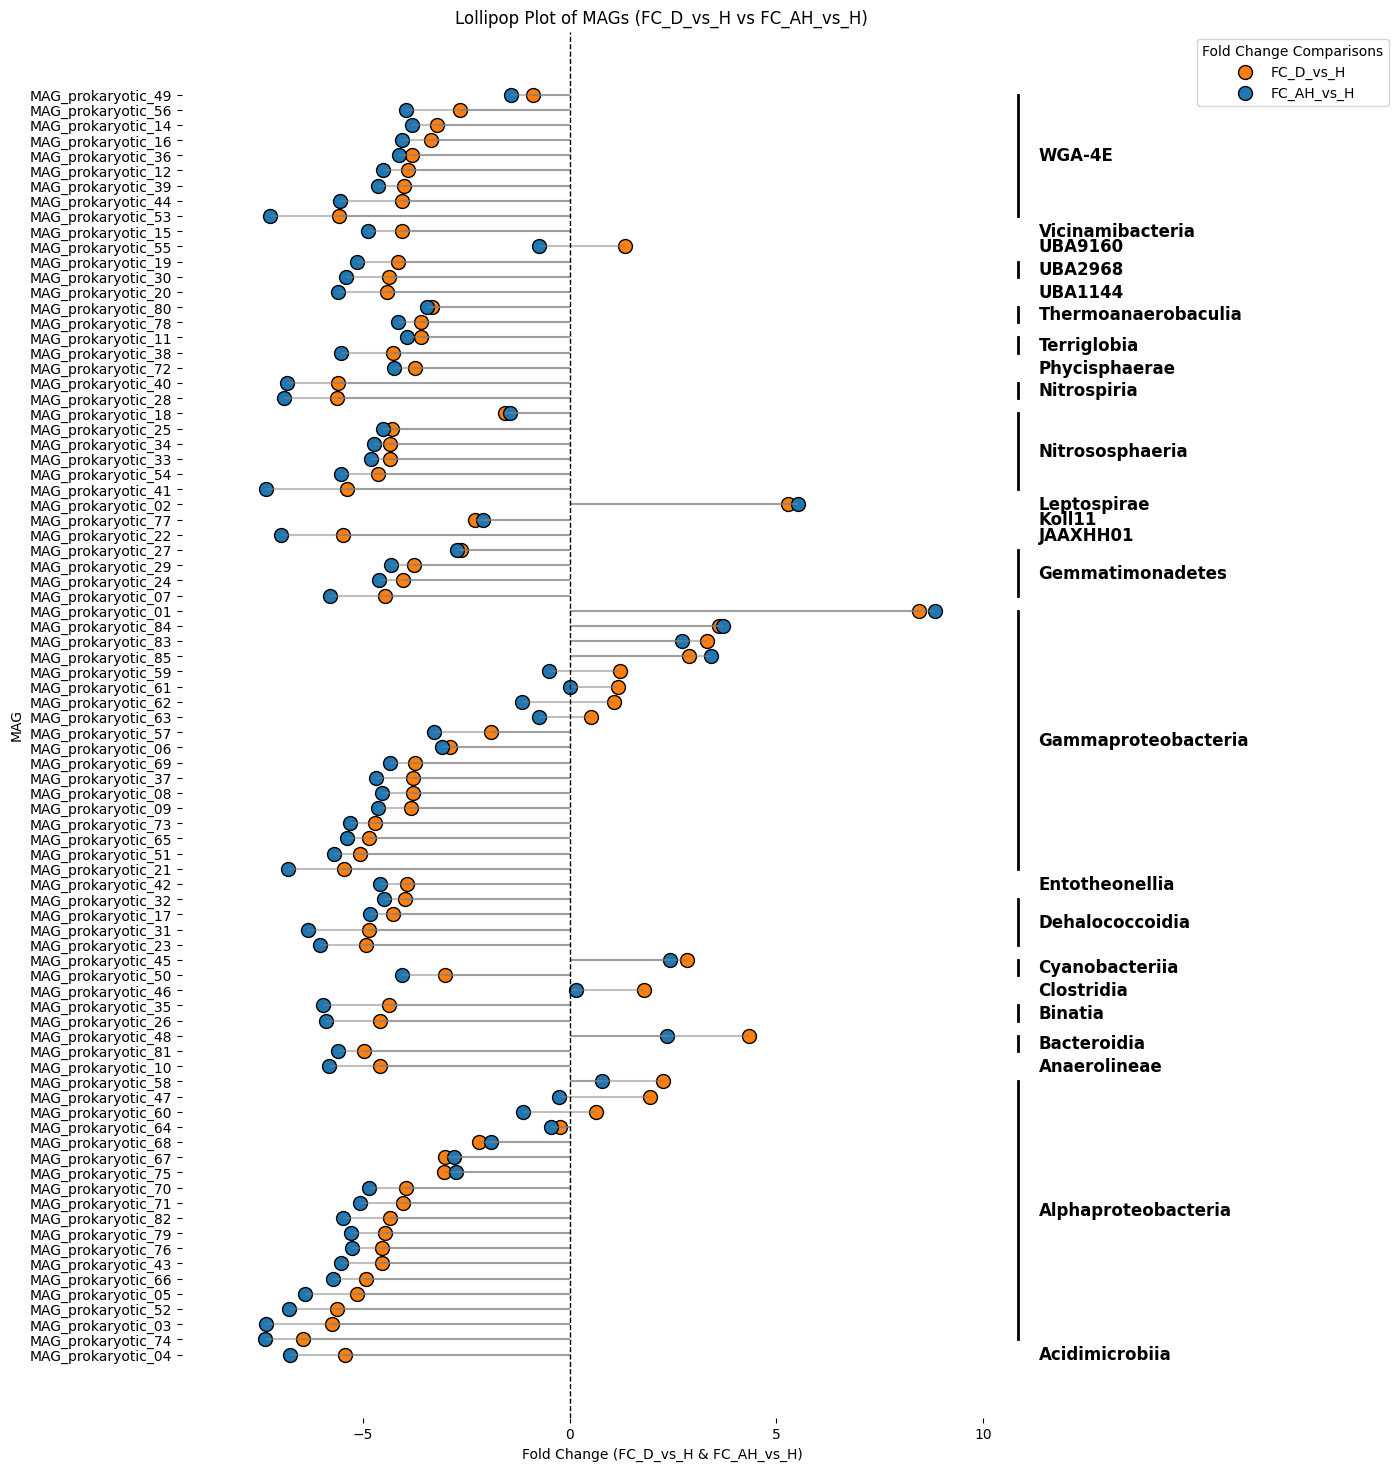

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/DAA_MannU_test.csv')
df.rename(columns={"Unnamed: 0": "MAG"}, inplace=True)
df = df.set_index("MAG")
df = df.loc[~df.index.str.contains("MAG_viral_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_plasmid_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_eukaryotic_", regex=False), :]

gtdb = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/gtdb_taxonomy.tsv', sep='\t')
gtdb = gtdb.set_index("MAG")
gtdb

merged_df = df.merge(gtdb, left_index=True, right_index=True)
merged_df


# Assuming merged_df is already loaded and processed
# Drop NaN values if needed
merged_df = merged_df.dropna(subset=["class", "FC_D_vs_H", "FC_AH_vs_H"])

# Sort by class and FC_D_vs_H
merged_df = merged_df.sort_values(by=["class", "FC_D_vs_H"], ascending=[True, True])

# Set up figure with larger size
fig, ax = plt.subplots(figsize=(16, 18))  # Increased figure size

# Define colors for two fold-change comparisons
color_d_vs_h = "#FF7F0E"  # Blue for FC_D_vs_H
color_ah_vs_h = "#1F77B4" 

# Get y-ticks positions
y_positions = np.arange(len(merged_df))

# Lollipop Plot (Two per MAG)
for class_name, subset in merged_df.groupby("class"):
    # FC_D_vs_H
    ax.hlines(y=subset.index, xmin=0, xmax=subset["FC_D_vs_H"], color="gray", alpha=0.5)
    ax.scatter(subset["FC_D_vs_H"], subset.index, label="FC_D_vs_H" if class_name == merged_df["class"].iloc[0] else "", 
               s=100, edgecolor="black", color=color_d_vs_h)

    # FC_AH_vs_H
    ax.hlines(y=subset.index, xmin=0, xmax=subset["FC_AH_vs_H"], color="gray", alpha=0.5)
    ax.scatter(subset["FC_AH_vs_H"], subset.index, label="FC_AH_vs_H" if class_name == merged_df["class"].iloc[0] else "", 
               s=100, edgecolor="black", color=color_ah_vs_h)

# Add class brackets on the **right** side of the y-axis
current_y = 0  # Track y-axis position
for class_name, subset in merged_df.groupby("class"):
    start_y = current_y  # First MAG in the class
    end_y = current_y + len(subset) - 1  # Last MAG in the class
    mid_y = (start_y + end_y) / 2  # Midpoint for labeling

    # Get the maximum x-value to position class labels dynamically
    max_x = max(merged_df["FC_D_vs_H"].max(), merged_df["FC_AH_vs_H"].max()) + 2  

    # Draw a bracket ] on the right side
    ax.plot([max_x, max_x], [start_y, end_y], color="black", linewidth=2)  # Vertical line
    ax.text(max_x + 0.5, mid_y, class_name, ha="left", va="center", fontsize=12, fontweight="bold")  # Shifted text further right

    current_y += len(subset)  # Move to next group


for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
    
# Adjust plot layout
plt.subplots_adjust(left=0.2, right=0.8)  # Adjust spacing to fit class labels

# Add labels and formatting
ax.axvline(0, color="black", linewidth=1, linestyle="dashed")  # Zero reference line
ax.set_xlabel("Fold Change (FC_D_vs_H & FC_AH_vs_H)")
ax.set_ylabel("MAG")
ax.set_title("Lollipop Plot of MAGs (FC_D_vs_H vs FC_AH_vs_H)")

# Add legend for the two FC values
ax.legend(title="Fold Change Comparisons", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust x-axis limits dynamically to leave extra space
x_min = min(merged_df["FC_D_vs_H"].min(), merged_df["FC_AH_vs_H"].min()) - 2  # Extra space on the left
x_max = max(merged_df["FC_D_vs_H"].max(), merged_df["FC_AH_vs_H"].max()) + 5  # Extra space on the right for labels
ax.set_xlim(x_min, x_max)

# Save as PDF
plt.savefig("/Users/Shrini/Desktop/desktop_SCTLD_Complete/Output/prelim_main_figs/Lollipop_MAGs_class_bacteria.pdf", dpi=300, bbox_inches="tight")

# Show plot
plt.show()


## c) Comparing Virulence factors

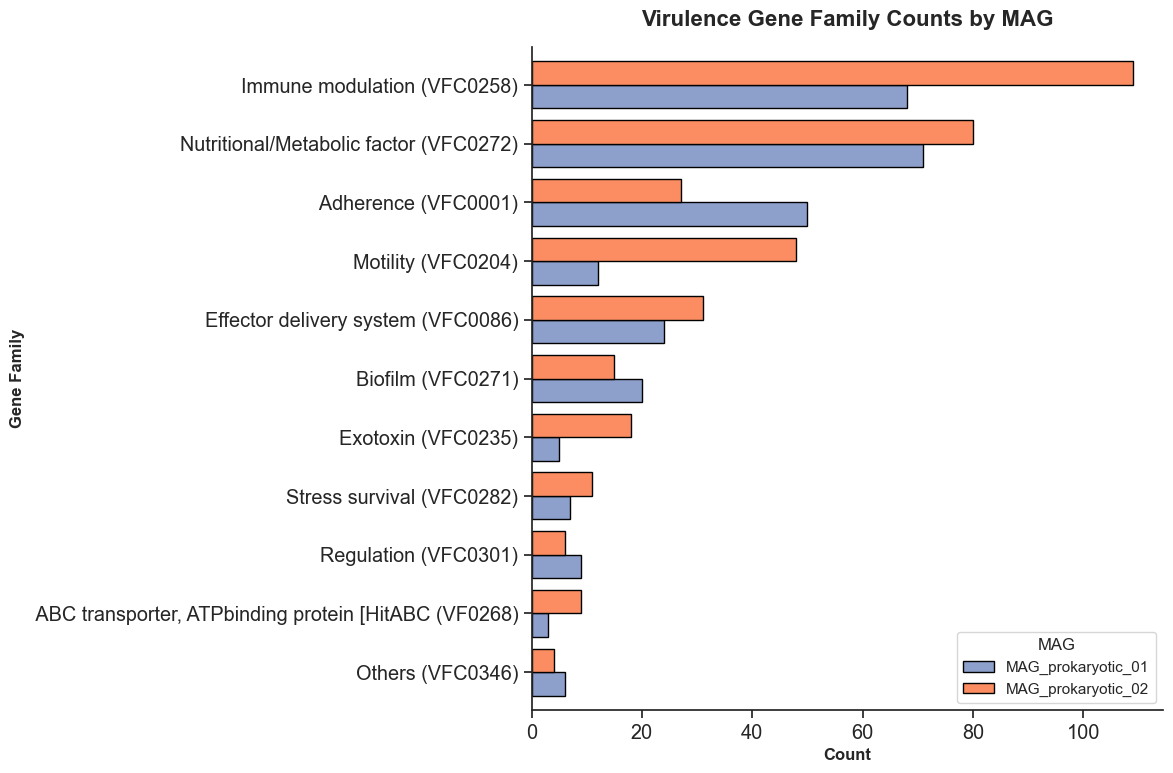

In [29]:

# VFDB blast code 
#/home/timothy/programs/DIAMOND_v2.1.10/bin/diamond blastp --ultra-sensitive --max-target-seqs 1 --evalue 0.00001 --query merged_fasta.faa --db /scratch/databases/VFDB/VFDB_db.dmnd --out phylo2_viral_proteins_nr.tsv --threads 60 --outfmt 6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and filter VFDB data
df = pd.read_csv("/Users/Shrini/Desktop/desktop_SCTLD_Complete/VFDB_blast_results.tsv", sep='\t')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df[df['qseqid'].str.contains("MAG_prokaryotic_01|MAG_prokaryotic_02")]
df['MAG'] = df['qseqid'].str.extract(r'(MAG_prokaryotic_\d+)')

# Count occurrences
grouped = df.groupby(['gene_family', 'MAG']).size().reset_index(name='count')

# Keep gene families with total count ≥10
filtered = grouped.groupby('gene_family').filter(lambda x: x['count'].sum() >= 10)

# Pivot to counts matrix
counts_table = filtered.pivot(index='gene_family', columns='MAG', values='count').fillna(0).astype(int)

# Sort gene families by total count for better visualization
counts_table["Total"] = counts_table.sum(axis=1)
counts_table = counts_table.sort_values("Total", ascending=True).drop(columns="Total")

# Set Seaborn style
sns.set(style="ticks", font_scale=1.3)

# Custom Set2 colors (same color mapping as before)
custom_colors = {
    "MAG_prokaryotic_01": "#8da0cb",  # blue
    "MAG_prokaryotic_02": "#fc8d62",  # orange
}
color_list = [custom_colors.get(mag, "#999999") for mag in counts_table.columns]

# Plot
ax = counts_table.plot(
    kind='barh',
    stacked=False,
    figsize=(12, 8),
    color=color_list,
    edgecolor='black',
    width=0.8
)

# Aesthetics
plt.xlabel("Count", fontsize=12, fontweight='bold')
plt.ylabel("Gene Family", fontsize=12, fontweight='bold')
plt.title("Virulence Gene Family Counts by MAG", fontsize=16, fontweight='bold', pad=15)
plt.legend(title="MAG", title_fontsize=12, fontsize=11)
sns.despine()
plt.tight_layout()

# Save or show
#plt.savefig("/Users/Shrini/Desktop/pretty_virulence_counts.pdf", bbox_inches="tight")
plt.show()


# 3. Viruses Work

## a) Relative Abundance

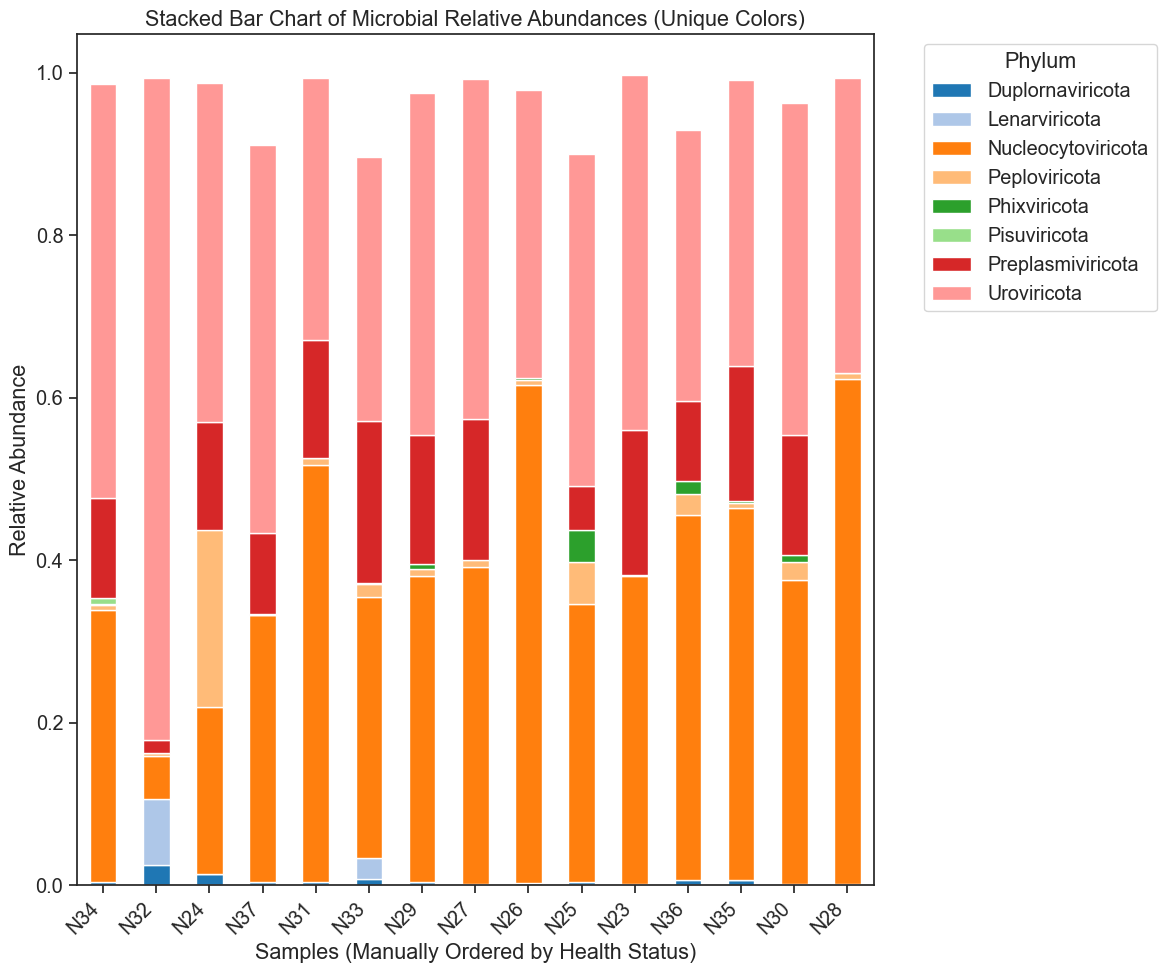

,Phylum,Comparison,U-Statistic,P-value,Group1,Group2,Median_Group1,Median_Group2,Direction,Adjusted P-value
0,Duplornaviricota,H vs DS,13.0,0.142857,Healthy (H),Diseased (DS),0.014032,0.003314,Down,0.571429
1,Duplornaviricota,H vs AH,13.0,0.142857,Healthy (H),AH,0.014032,0.001742,Down,0.571429
2,Duplornaviricota,DS vs AH,15.0,0.690476,Diseased (DS),AH,0.003314,0.001742,Down,0.920635
3,Lenarviricota,H vs DS,10.5,0.427124,Healthy (H),Diseased (DS),0.000087,0.000000,Down,0.806723
4,Lenarviricota,H vs AH,10.0,0.541193,Healthy (H),AH,0.000087,0.000002,Down,0.806723
5,Lenarviricota,DS vs AH,12.0,1.000000,Diseased (DS),AH,0.000000,0.000002,Up,1.000000
6,Nucleocytoviricota,H vs DS,1.0,0.071429,Healthy (H),Diseased (DS),0.205423,0.376217,Up,0.571429
7,Nucleocytoviricota,H vs AH,0.0,0.035714,Healthy (H),AH,0.205423,0.449583,Up,0.571429
8,Nucleocytoviricota,DS vs AH,7.0,0.309524,Diseased (DS),AH,0.376217,0.449583,Up,0.742857
9,Peploviricota,H vs DS,5.0,0.571429,Healthy (H),Diseased (DS),0.006516,0.009173,Up,0.806723


In [30]:
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")
df = df.loc[~df.index.str.contains("MAG_prokaryotic_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_plasmid_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_eukaryotic_", regex=False), :]
df = df[df.index != "unmapped"]
df = df.filter(like="TPM_")

#generate relative abundances
# Compute relative abundances
df_relative = df.div(df.sum(axis=0), axis=1) # divide each columns value based on the sum of the column

# Rename columns to include 'RA_' prefix
df_relative = df_relative.add_prefix('RA_')

# Merge with the original dataframe

virus_tax = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/viral_mag_taxonomy.csv')
virus_tax = virus_tax.set_index("MAG")

df_relative_taxa = pd.merge(df_relative, virus_tax, left_index=True, right_index=True)
df_relative_taxa.columns = df_relative_taxa.columns.str.replace("RA_TPM_", "", regex=False)

manual_order = [ "N34", "N32", "N24","N37","N31",  # Healthy (H)
                "N33", "N29", "N27", "N26", "N25",  # Diseased (DS)
                "N23", "N36", "N35", "N30", "N28"]  # AH

# Extract numeric data (samples)
numeric_df = df_relative_taxa.select_dtypes(include=["number"])

# Extract 'class' column for grouping
metadata_class = df_relative_taxa["phylum"]

# Group by 'class'
grouped_df = numeric_df.groupby(metadata_class).sum()

# Transpose for plotting
grouped_df = grouped_df.T

# Manually reorder the samples
grouped_df = grouped_df.loc[manual_order]

# Generate unique colors for up to 24 classes
num_classes = len(grouped_df.columns)
color_palette = sns.color_palette("tab20", min(num_classes, 20)) + sns.color_palette("Set3", max(0, num_classes - 20))

# Plot stacked bar chart with unique colors
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(12, 10), color=color_palette)

# Formatting
plt.xlabel("Samples (Manually Ordered by Health Status)")
plt.ylabel("Relative Abundance")
plt.title("Stacked Bar Chart of Microbial Relative Abundances (Unique Colors)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Phylum", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
#plt.savefig('/Users/Shrini/Desktop/desktop_SCTLD_Complete/Images/phylum_virus_relative_abundance.pdf')
plt.show()


# Convert to DataFrame and adjust p-values for multiple testing
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Define sample groups
h_samples = ["N34", "N32", "N24"]  # Healthy (H)
ds_samples = ["N33", "N29", "N27", "N26", "N25"]  # Diseased (DS)
ah_samples = ["N23", "N36", "N35", "N30", "N28"]  # AH

# Extract numerical data and group by phylum
numeric_df = df_relative_taxa.select_dtypes(include=["number"])
grouped_df = numeric_df.groupby(df_relative_taxa["phylum"]).sum().T

# Statistical tests
pairwise_results_with_groups = []
phylum_pvals = {}
pairwise_results_with_medians = []

for phylum in grouped_df.columns:
    h_vals = grouped_df.loc[h_samples, phylum]
    ds_vals = grouped_df.loc[ds_samples, phylum]
    ah_vals = grouped_df.loc[ah_samples, phylum]

    # Kruskal-Wallis test across all groups
    stat, pval = kruskal(h_vals, ds_vals, ah_vals)
    phylum_pvals[phylum] = pval

    # Mann-Whitney U tests
    for (group1, group2, label, group1_name, group2_name) in [
        (h_vals, ds_vals, "H vs DS", "Healthy (H)", "Diseased (DS)"),
        (h_vals, ah_vals, "H vs AH", "Healthy (H)", "AH"),
        (ds_vals, ah_vals, "DS vs AH", "Diseased (DS)", "AH")
    ]:
        stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
        median1, median2 = np.median(group1), np.median(group2)
        direction = "Up" if median1 < median2 else "Down"
        pairwise_results_with_medians.append([phylum, label, stat, pval, group1_name, group2_name, median1, median2, direction])

# Convert results to a dataframe
pairwise_df_with_medians = pd.DataFrame(pairwise_results_with_medians,
                                        columns=["Phylum", "Comparison", "U-Statistic", "P-value",
                                                 "Group1", "Group2", "Median_Group1", "Median_Group2", "Direction"])

# Adjust p-values for multiple testing
pairwise_df_with_medians["Adjusted P-value"] = multipletests(pairwise_df_with_medians["P-value"], method="fdr_bh")[1]

# Filter significant results
#significant_pairwise_df_with_medians = pairwise_df_with_medians[pairwise_df_with_medians["Adjusted P-value"] < 0.05]
significant_pairwise_df_with_medians = pairwise_df_with_medians[pairwise_df_with_medians["P-value"] < 0.05]

pairwise_df_with_medians


# b) Other plots 
Viral lollipop plots were generated using the same code as done for Prokaryotes and has not been included in this notebook. 

# 4. Differential Abundance


## a) DESEQ2 

In [31]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats


reads = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
tpm_columns = [col for col in reads.columns if "TPM" in col]

# Step 2: Count how many TPM columns in each row are > 1.0
tpm_gt1_counts = (reads[tpm_columns] > 1.0).sum(axis=1) 

# Step 3: Filter rows where that count is at least 5
filtered_reads = reads[tpm_gt1_counts >= 2]
# Step 1: Identify 'Read_Count' columns
read_count_columns = [col for col in filtered_reads.columns if 'Read Count_' in col]

# Step 2: Combine with 'MAG' column
subset_columns = ['MAG'] + read_count_columns

# Step 3: Subset the DataFrame
final_subset = filtered_reads[subset_columns]
final_subset.columns = [col.replace('Read Count_', '') for col in final_subset.columns]

transposed_data = final_subset.set_index("MAG")

transposed_data = transposed_data.transpose()

transposed_data = transposed_data.fillna(0).astype(int).astype(float)

metadata = pd.read_csv("/Users/Shrini/Desktop/desktop_SCTLD_Complete/SCTLD_metadata.csv")
metadata = metadata.rename(columns={'Sample': 'MAG'})
metadata = metadata.set_index("MAG")


# order the index correctly
print(transposed_data.index)
print(metadata.index)
# Sort indices in transposed_data
transposed_data_sorted = transposed_data.sort_index()
# Drop rows with index 'N31' and 'N37'
transposed_data_sorted = transposed_data_sorted.drop(index=["N31", "N37"], errors='ignore')

# Sort indices in metadata
metadata_sorted = metadata.sort_index()
metadata_sorted = metadata_sorted.drop(index=["N31", "N37"], errors='ignore')

# Print sorted indices
print(transposed_data_sorted.index)
print(metadata_sorted.index)



dds = DeseqDataSet(
    counts=transposed_data_sorted,
    metadata=metadata_sorted,
    design_factors=["Health"],
    refit_cooks=True)

# Compute normalization factors
dds.fit_size_factors()

dds.obsm["size_factors"]

# Fit genewise dispersions
dds.fit_genewise_dispersions()

dds.varm["genewise_dispersions"]

# Fit dispersion trend coefficients
dds.fit_dispersion_trend()
dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]

# Dispersion priors
dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)

# MAP dispersion
dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]

# Fit log fold changes
dds.fit_LFC()
dds.varm["LFC"]

dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()


results = {}

# Define treatment groups (excluding the reference group 'Healthy')
treatment_groups = ["DS", "AH"]
ref_group = "H"

for group in treatment_groups:
    print(f"Processing {group} vs {ref_group}...")

    # Create DeseqStats object for each treatment vs Healthy
    ds = DeseqStats(
        dds,
        contrast=["Health", group, ref_group],
        alpha=0.05,
        cooks_filter=True,
        independent_filter=True,
    )

    # Compute statistics
    ds.summary()

    # Extract relevant results
    df_results = ds.results_df[["log2FoldChange", "pvalue", "padj"]].rename(
        columns={
            "log2FoldChange": f"{group}_log2FC",
            "pvalue": f"{group}_pvalue",
            "padj": f"{group}_padj"
        }
    )

    # Store results
    results[group] = df_results

# Combine into one DataFrame
final_results = pd.concat(results.values(), axis=1)
final_results.to_csv("/Users/Shrini/Desktop/DESEQ2.csv")


Index(['N23', 'N36', 'N37', 'N35', 'N34', 'N33', 'N32', 'N31', 'N30', 'N29',
       'N28', 'N27', 'N26', 'N25', 'N24'],
      dtype='object')
Index(['N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32',
       'N33', 'N34', 'N35', 'N36', 'N37'],
      dtype='object', name='MAG')
Index(['N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N32', 'N33',
       'N34', 'N35', 'N36'],
      dtype='object')
Index(['N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N32', 'N33',
       'N34', 'N35', 'N36'],
      dtype='object', name='MAG')


Fitting size factors...
... done in 0.00 seconds.

/Users/Shrini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Shrini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Shrini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Shrini/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or n

logres_prior=1.0056453945364756, sigma_prior=0.7843224387993603


... done in 0.21 seconds.

Fitting LFCs...
... done in 0.27 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Processing DS vs H...


... done in 0.17 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Health DS vs H
                        baseMean  log2FoldChange       lfcSE      stat  \
MAG                                                                      
MAG_prokaryotic_31   2223.342863       -6.813738    1.707645 -3.990137   
MAG_prokaryotic_33   5962.026415      -10.893643    2.215531 -4.916944   
MAG_viral_141         415.154212        5.079576    3.205778  1.584507   
MAG_viral_054         300.303872        6.457577    2.682679  2.407137   
MAG_plasmid_23         44.890086       36.441480  172.700655  0.211010   
...                          ...             ...         ...       ...   
MAG_viral_133          85.921934      -18.944490   18.729345 -1.011487   
MAG_viral_140          78.441268        0.772881    1.769786  0.436709   
MAG_prokaryotic_28   4718.315171       -9.315845    2.029489 -4.590242   
MAG_prokaryotic_19  12312.628729       -6.675509    1.361111 -4.904455   
MAG_viral_118          23.156712      -20.523240   91.23463

... done in 0.15 seconds.



In [33]:
# for filtering significant results 
pvalue_columns = [col for col in final_results.columns if 'pvalue' in col]

# Drop rows where any pvalue column is NaN
final_results_filtered = final_results.dropna(subset=pvalue_columns)
final_results_filtered

# Identify columns that contain 'padj'
padj_columns = [col for col in final_results_filtered.columns if 'padj' in col]

# Create a mask for rows with any padj < 0.05
significant_mask = (final_results_filtered[padj_columns] < 0.05).any(axis=1)

# Subset the DataFrame
significant_results = final_results_filtered[significant_mask]


## b) TPM based fold change 

In [ ]:
Sample_ID = pd.read_excel("/Users/shrinivas/Desktop/desktop_SCTLD_Complete/SCTLD_metadata.xlsx")
tpm.index = tpm.index.str.replace('TPM_', '', regex=False)
counts = tpm
counts = counts.transpose()
counts = counts + 1
counts.index = counts.index.str.split('_').str[0]
counts = counts.reset_index()
counts.rename(columns={"index": "Sample"}, inplace=True)

counts = pd.read_csv('/Users/shrinivas/Desktop/desktop_SCTLD_Complete/tmp.csv')
counts = counts.set_index("Sample")
counts = counts.transpose()


# prepr the data for DAA 
# Filter for each treatment group
T1_samples = Sample_ID[Sample_ID['Health'] == 'DS']
T2_samples = Sample_ID[Sample_ID['Health'] == 'AH']
T3_samples = Sample_ID[Sample_ID['Health'] == 'H']


# extract the Sample_ID for each group 
T1_sample_ids = T1_samples['Sample'].tolist()
T2_sample_ids = T2_samples['Sample'].tolist()
T3_sample_ids = T3_samples['Sample'].tolist()


# filter MAGs table samples based on this classification
T1_metabolites = counts[T1_sample_ids]  # Diseased
T2_metabolites = counts[T2_sample_ids]  # AH
T3_metabolites = counts[T3_sample_ids]    # Healthy

#n 31 and 37 are weird 

T3_metabolites = T3_metabolites.drop(columns=['N37', 'N31']) # dropping the weird samples


# load in packages 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Find metabolites to keep based on row sums (non-zero rows in all groups)
t1 = np.where(T1_metabolites.sum(axis=1) > 0)[0]
t2 = np.where(T2_metabolites.sum(axis=1) > 0)[0]
t3 = np.where(T3_metabolites.sum(axis=1) > 0)[0]
tokeep = np.union1d(np.union1d(t1, t2), t3)

# perform the MWU test for each of the samples. Our key comparisions are DS vs H; AH vs H; DS vs AH
# Initialize lists to store p-values for each pairwise comparison
pval_D_vs_H = []  # Diseased vs Healthy
pval_AH_vs_H = []  # AH vs Healthy
pval_D_vs_AH = []  # Diseased vs AH

# Perform Mann-Whitney U test for each metabolite (pairwise comparisons)
for i in range(len(tokeep)):
    # Diseased vs Healthy
    _, p_value_D_vs_H = mannwhitneyu(T1_metabolites.iloc[i], T3_metabolites.iloc[i], alternative='two-sided')
    pval_D_vs_H.append(p_value_D_vs_H)
    
    # AH vs Healthy
    _, p_value_AH_vs_H = mannwhitneyu(T2_metabolites.iloc[i], T3_metabolites.iloc[i], alternative='two-sided')
    pval_AH_vs_H.append(p_value_AH_vs_H)
    
    # Diseased vs AH
    _, p_value_D_vs_AH = mannwhitneyu(T1_metabolites.iloc[i], T2_metabolites.iloc[i], alternative='two-sided')
    pval_D_vs_AH.append(p_value_D_vs_AH)
    


# Adjust p-values using Benjamini-Hochberg method (FDR correction)
pvalAdj_D_vs_H = multipletests(pval_D_vs_H, method='fdr_bh')[1]
pvalAdj_AH_vs_H = multipletests(pval_AH_vs_H, method='fdr_bh')[1]
pvalAdj_D_vs_AH = multipletests(pval_D_vs_AH, method='fdr_bh')[1]


# calculate the log2FC \
# Calculate log2 fold change for T1 (Diseased), T2 (AH), and T3 (Healthy)
T1_log2 = np.log2(T1_metabolites)
T1_log2.replace(-np.inf, 0, inplace=True)
T1_mean = T1_log2.mean(axis=1)

T2_log2 = np.log2(T2_metabolites)
T2_log2.replace(-np.inf, 0, inplace=True)
T2_mean = T2_log2.mean(axis=1)

T3_log2 = np.log2(T3_metabolites)
T3_log2.replace(-np.inf, 0, inplace=True)
T3_mean = T3_log2.mean(axis=1)

# Calculate fold change for each comparison
foldchange_D_vs_H = T1_mean - T3_mean  # Diseased vs Healthy
foldchange_AH_vs_H = T2_mean - T3_mean  # AH vs Healthy
foldchange_D_vs_AH = T1_mean - T2_mean  # Diseased vs AH

stats = pd.DataFrame({
    'FC_D_vs_H': foldchange_D_vs_H,
    'FC_AH_vs_H': foldchange_AH_vs_H,
    'FC_D_vs_AH': foldchange_D_vs_AH,
    'pval_D_vs_H': pval_D_vs_H,
    'ADJPVALUE_D_vs_H': pvalAdj_D_vs_H,
    'pval_AH_vs_H': pval_AH_vs_H,
    'ADJPVALUE_AH_vs_H': pvalAdj_AH_vs_H,
    'pval_D_vs_AH': pval_D_vs_AH,
    'ADJPVALUE_D_vs_AH': pvalAdj_D_vs_AH
})

print(stats)

# 5. MAGs of interest

## a) Box plots

In [66]:
import math

# Set max columns
ncols = 2
nrows = math.ceil(len(mags_sorted) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 16), dpi=300, sharey=False)
axes = axes.flatten()

for i, mag in enumerate(mags_sorted):
    ax = axes[i]
    data_mag = df_plot[df_plot["MAG"] == mag]

    sns.boxplot(
        data=data_mag,
        x="Condition", y="TPM",
        palette=custom_palette, order=condition_order,
        ax=ax, linewidth=1
    )
    
    ax.set_title(mag, fontsize=13, fontweight='bold', pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("TPM", fontsize=11)
    ax.tick_params(axis='x', labelrotation=45)
    sns.despine(ax=ax)

    # Add significance stars
    stat_row = stats_data[stats_data["MAG"] == mag]
    if not stat_row.empty:
        ds_star = pval_to_stars(stat_row["DS_padj"].values[0])
        ah_star = pval_to_stars(stat_row["AH_padj"].values[0])
        y_max = data_mag["TPM"].max()
        y_star = y_max * 1.05

        if ds_star:
            ax.text(2, y_star, ds_star, ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')
        if ah_star:
            ax.text(1, y_star, ah_star, ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')

# Hide unused subplots if any
for j in range(len(mags_sorted), len(axes)):
    axes[j].axis("off")

plt.suptitle("TPM of Selected MAGs by Condition", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
#plt.savefig("/Users/Shrini/Desktop/tpm_mags_2_per_row.pdf", bbox_inches='tight')
plt.show()


NameError: name 'mags_sorted' is not defined

# 6. Phylogenetics

**Note: The vast majority of this code was run on bash**
## a) Generating trees

In [35]:
#step1: blast
/home/timothy/programs/DIAMOND_v2.1.10/bin/diamond blastp --ultra-sensitive --max-target-seqs 0 --evalue 0.00001 --query all_vmag.faa --db /scratch/shrinivas/Databases/IMG_VR/IMG_VR_2022-12-19_7/diamond_db_IMGVR.dmnd --out viral_proteins_imgvr.tsv --threads 60 --outfmt 6 "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen stitle staxids"

/home/timothy/programs/DIAMOND_v2.1.10/bin/diamond blastp --ultra-sensitive --max-target-seqs 0 --evalue 0.00001 --query all_vmag.faa --db /scratch/databases/ncbi/2022_07/nr.dmnd --out viral_proteins_nr.tsv --threads 60 --outfmt6 "qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen stitle staxids sblastnames"

#step2: downsample nr 
zcat viral_proteins_nr.tsv.gz | /home/timothy/GitHub/Utils/Blast/taxonomically_downsample_hits/taxonomically_downsample_hits.sh --taxid_col 16 --target_taxa class --num_seqs_per_taxid 1 > downsampled_hits.tsv

# select only top 50 for viruses cuz they are way too many 
#!/bin/bash

faa_path="/scratch/shrinivas/Databases/IMG_VR/IMG_VR_2022-12-19_7/IMGVR_all_proteins.faa.gz"
seqkit="/home/timothy/programs/seqkit_v2.3.1/seqkit"

mkdir -p top50_imgvr_fasta

for file in *.tsv; do
    base=$(basename "$file" .tsv)

    # Step 1: Sort by bitscore (column 12), get top 50
    sort -k12,12nr "$file" | head -n 50 > "${base}.top50.tsv"

    # Step 2: Extract accession IDs (column 2)
    cut -f2 "${base}.top50.tsv" > "${base}.top50.ids"

    # Step 3: Extract sequences with seqkit
    "$seqkit" grep -f "${base}.top50.ids" "$faa_path" > "top50_imgvr_fasta/imgvr.${base}.top50.fa"
done


# merge the two files 
#!/bin/bash

imgvr_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/imgvr_files/qseqid_split_files/top50_imgvr_fasta"
nr_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/nr_files/qseqid_split_files/fasta_files"
merged_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/database_results_merged"
log_file="${merged_dir}/merge_log.txt"

mkdir -p "$merged_dir"
echo -e "Base\tNR_Count\tIMGVR_Count\tMerged_Count\tStatus" > "$log_file"

all_bases=$( (ls "$imgvr_dir"/imgvr.*.top50.fa "$nr_dir"/nr.*.fa 2>/dev/null | \
    sed 's|.*/||' | sed 's/^imgvr\.//; s/\.top50\.fa$//' | sed 's/^nr\.//; s/\.fa$//' ) | sort -u )

for base in $all_bases; do
    imgvr_file="$imgvr_dir/imgvr.${base}.top50.fa"
    nr_file="$nr_dir/nr.${base}.fa"
    out_file="$merged_dir/${base}.merged.fa"

    # Count sequences using grep on '>'
    imgvr_count=0
    nr_count=0
    merged_count=0
    status=""

    [[ -f "$imgvr_file" ]] && imgvr_count=$(grep -c '^>' "$imgvr_file")
    [[ -f "$nr_file" ]] && nr_count=$(grep -c '^>' "$nr_file")

    if [[ -f "$imgvr_file" && -f "$nr_file" ]]; then
        cat "$imgvr_file" "$nr_file" > "$out_file"
        merged_count=$(grep -c '^>' "$out_file")
        status="Merged"
    elif [[ -f "$imgvr_file" ]]; then
        cp "$imgvr_file" "$out_file"
        merged_count=$imgvr_count
        status="Only_IMGVR"
    elif [[ -f "$nr_file" ]]; then
        cp "$nr_file" "$out_file"
        merged_count=$nr_count
        status="Only_NR"
    else
        status="Missing_Both"
    fi

    echo -e "${base}\t${nr_count}\t${imgvr_count}\t${merged_count}\t${status}" >> "$log_file"
done


#### add in the actual sequences too 
#!/bin/bash

merged_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/database_results_merged"
all_vmag="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/all_vmag.faa"
seqkit="/home/timothy/programs/seqkit_v2.3.1/seqkit"
log_file="$merged_dir/sequence_append_log.txt"

echo -e "File\tAppended_Sequence\tStatus" > "$log_file"

for merged_file in "$merged_dir"/*.merged.fa; do
    base=$(basename "$merged_file" .merged.fa)

    # Write the sequence ID to a temporary file
    echo "$base" > tmp_id.txt

    # Check if the sequence exists in the master file
    match_count=$("$seqkit" grep -f tmp_id.txt "$all_vmag" | grep -c '^>')

    if [[ "$match_count" -gt 0 ]]; then
        "$seqkit" grep -f tmp_id.txt "$all_vmag" >> "$merged_file"
        echo -e "${base}.merged.fa\t$base\tAppended" >> "$log_file"
    else
        echo -e "${base}.merged.fa\t$base\tNot_Found" >> "$log_file"
    fi
done

# Clean up
rm -f tmp_id.txt


#### Run Mafft to align each gene file 
#iet the source directory for merged files
source_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/database_results_merged"

# Set the destination directory for aligned files
destination_dir="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/database_results_aligned"

# Ensure the destination directory exists
mkdir -p "$destination_dir"

# Set the number of threads to use
threads=40  # Change this number based on your system's capabilities

# Run mafft for each input file in parallel
find "$source_dir" -type f -name "*.merged.fa" | \
        xargs -I {} -P "$threads" bash -c '/home/shrinivas/Programs/mafft-linux64/mafft.bat --localpair --maxiterate 1000 "{}" > "'"$destination_dir"'"/$(basename "{}" .merged.fa).aligned.fa'


##### Use trimal to trim aligned reads 
#set the input directory: aligned files from MAFFT step
input_directory="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/database_results_aligned"

# Output trimmed files in the same directory
for file in "$input_directory"/*.aligned.fa; do
            # Extract filename without extension
    filename=$(basename "$file" .aligned.fa)
                    
    # Run TrimAl
    trimal -automated1 -in "$file" -out "${input_directory}/${filename}.aligned.trimmed.fa"
done


#### Run IQTREE

#!/bin/bash


#ource and destination paths
source_directory="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/aligned_trimmed_files"
destination_directory="/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/SCTLD_complete/phylogenetics_viral_mags/iqtree_results"
mkdir -p "$destination_directory"

# Generate only actual commands for parallel to execute
find "$source_directory" -type f -name "*.fa" | while read source_file; do
    filename=$(basename "$source_file")
    base="${filename%.*}"
    prefix="$destination_directory/$base"

    echo "/home/timothy/programs/iqtree-1.6.12-Linux/bin/iqtree -s \"$source_file\" -m TEST -bb 1000 -nt AUTO -pre \"$prefix\""
    done | parallel -j 20

echo "IQ-TREE process complete."

                
                

SyntaxError: invalid syntax (2976886014.py, line 2)

## b) Plotting Trees

In [28]:
import pandas as pd
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/filtered_IMGVR_cols_with_taxonomy.tsv', sep='\t', header=None)
df.drop(columns=[2, 3, 4], inplace=True, errors='ignore')

df[1] = df[1].apply(lambda x: x if isinstance(x, str) and 'r_' in x else 'no_taxonomy')

df[2] = df[0] + '_' + df[1]
df.columns = ['name', 'Taxonomy', 'name_taxonomy']

nr = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/nr_naming_scheme.tsv', sep='\t', header=None)
nr.columns = ['name', 'Taxonomy', 'name_taxonomy']
name_scheme = pd.concat([nr, df], ignore_index=True)
name_scheme.drop(columns=['Taxonomy'], inplace=True)
name_scheme['name_taxonomy'] = name_scheme['name_taxonomy'].str.replace(';', '_', regex=False)
name_scheme.to_csv("/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/complete_naming_scheme.tsv")

# rename newick tree files
import os
tsv_file = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/complete_naming_scheme.tsv"  # Replace with actual path
tree_dir = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/"
output_dir = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/updated_trees/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Read the naming file
# Assumes columns: name, name_taxonomy
name_mapping = pd.read_csv(tsv_file)  # Or add header=None, names=["name", "name_taxonomy"] if needed
name_dict = dict(zip(name_mapping["name"], name_mapping["name_taxonomy"]))

# Loop through tree files and apply renaming
for filename in os.listdir(tree_dir):
    if filename.endswith(".treefile"):
        newick_path = os.path.join(tree_dir, filename)
        output_path = os.path.join(output_dir, filename)

        with open(newick_path, "r") as file:
            newick_data = file.read()

        # Replace names in tree with taxonomy-annotated names
        for original, updated in name_dict.items():
            newick_data = newick_data.replace(original, updated)

        with open(output_path, "w") as file:
            file.write(newick_data)

        print(f"✅ Updated tree saved: {output_path}")

print("🎉 All tree files processed and renamed successfully!") 

# generate trees

import os
from ete3 import Tree, TreeStyle, TextFace

# Define input directory containing tree files and output directory for PDFs
tree_dir = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/updated_trees/"
output_dir = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/tree_figures/"
failed_trees_log = "/Users/Shrini/Desktop/desktop_SCTLD_Complete/result_to_desktop/failed_trees.log"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize a list to track failed files
failed_trees = []

# Loop through all .treefile files in the directory
for filename in os.listdir(tree_dir):
    if filename.endswith(".treefile"):  # Process only tree files
        try:
            newick_file = os.path.join(tree_dir, filename)
            output_pdf = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}.pdf")  # Save as .pdf

            # Load the full Newick string directly from the file
            with open(newick_file, "r") as file:
                newick_str = file.read().strip()  # Ensure no trailing whitespace

            # Load tree into ete3 with format=0 (raw Newick parsing)
            ete_tree = Tree(newick_str, format=0)  # format=0 ensures correct bootstrap parsing

            # Function to add bootstrap values as node labels
            for node in ete_tree.traverse():
                if not node.is_leaf():  # Bootstrap values are on internal nodes
                    if hasattr(node, "support"):  # Check if node has a bootstrap value
                        bootstrap_value = int(node.support)  # Convert to integer if possible
                        if bootstrap_value > 0:  # Only display meaningful bootstrap values
                            bootstrap_label = TextFace(str(bootstrap_value), fsize=10, bold=True)
                            node.add_face(bootstrap_label, column=0, position="branch-top")  # Place above branches

            # Configure tree style
            ts = TreeStyle()
            ts.show_leaf_name = True  # Ensure full names are displayed
            ts.scale = 20  # Scale branch lengths
            ts.show_branch_length = False  # Show branch lengths
            ts.show_branch_support = False  # Hide default bootstrap display (we manually add them)

            # Save tree as a PDF
            ete_tree.render(output_pdf, w=1000, units="px", tree_style=ts)

            print(f"Tree saved as PDF at: {output_pdf}")

        except Exception as e:
            print(f"⚠️ Error processing {filename}: {str(e)}")
            failed_trees.append(filename)  # Add to failed list

# Save failed trees list to a log file
if failed_trees:
    with open(failed_trees_log, "w") as log_file:
        log_file.write("\n".join(failed_trees))
    print(f"\n🚨 Some trees failed. Check the log: {failed_trees_log}")
else:
    print("\n✅ All tree files processed successfully!")




**Note: 16S tree for Leptospirae was made using a similar code, and has not been included in this notebook**


# Alternate Figure
### Viral Relative Abundance

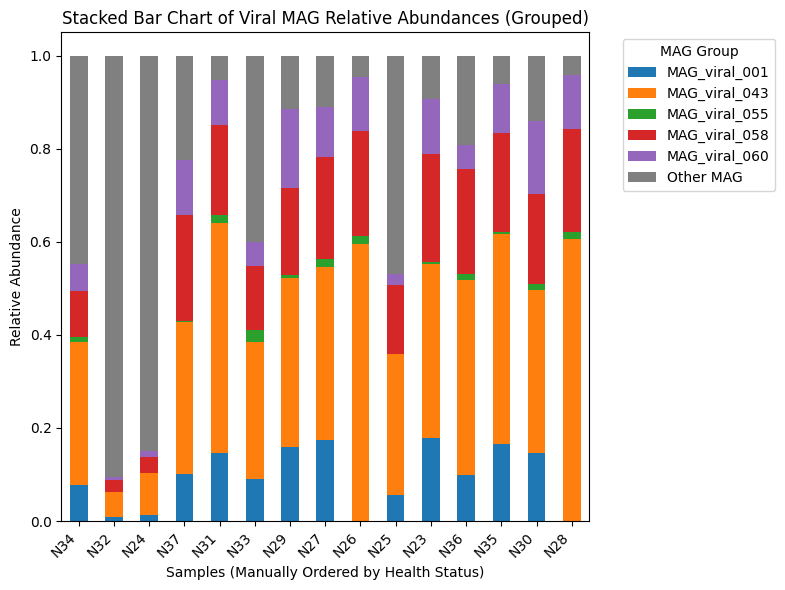

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")

# Filter out unwanted MAGs
df = df.loc[~df.index.str.contains("MAG_prokaryotic_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_plasmid_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_eukaryotic_", regex=False), :]
df = df[df.index != "unmapped"]

# Keep only TPM columns and calculate relative abundance
df = df.filter(like="TPM_")
df_relative = df.div(df.sum(axis=0), axis=1)
df_relative = df_relative.add_prefix('RA_')

# Define target MAGs
target_mags = {"MAG_viral_055", "MAG_viral_001", "MAG_viral_043", "MAG_viral_058", "MAG_viral_060"}

# Create MAG_group column
df_relative["MAG_group"] = df_relative.index.map(lambda x: x if x in target_mags else "Other MAG")

# Load taxonomy and merge
virus_tax = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/viral_mag_taxonomy.csv')
virus_tax = virus_tax.set_index("MAG")
df_relative_taxa = pd.merge(df_relative, virus_tax, left_index=True, right_index=True)

# Clean sample names
df_relative_taxa.columns = df_relative_taxa.columns.str.replace("RA_TPM_", "", regex=False)

# Manual sample order
manual_order = [ "N34", "N32", "N24","N37","N31",  # Healthy (H)
                 "N33", "N29", "N27", "N26", "N25",  # Diseased (DS)
                 "N23", "N36", "N35", "N30", "N28"]  # AH

# Select numeric data (i.e., sample columns)
numeric_df = df_relative_taxa[manual_order]

# Group by MAG_group
metadata_group = df_relative_taxa["MAG_group"]
grouped_df = numeric_df.groupby(metadata_group).sum()

# Transpose and reorder for plotting
grouped_df = grouped_df.T
grouped_df = grouped_df.loc[manual_order]

# Assign gray to 'Other MAG' and palette to others
unique_groups = grouped_df.columns.tolist()
custom_colors = {"Other MAG": "gray"}
other_mags = [mag for mag in unique_groups if mag != "Other MAG"]
palette = sns.color_palette("tab10", len(other_mags))
for mag, color in zip(other_mags, palette):
    custom_colors[mag] = color
color_list = [custom_colors[mag] for mag in unique_groups]

# Plot
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(8, 6), color=color_list)

# Formatting
plt.xlabel("Samples (Manually Ordered by Health Status)")
plt.ylabel("Relative Abundance")
plt.title("Stacked Bar Chart of Viral MAG Relative Abundances (Grouped)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="MAG Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/Users/Shrini/Desktop/viral_image_alternate.pdf", dpi = 300)
plt.show()


## For prokaryotes

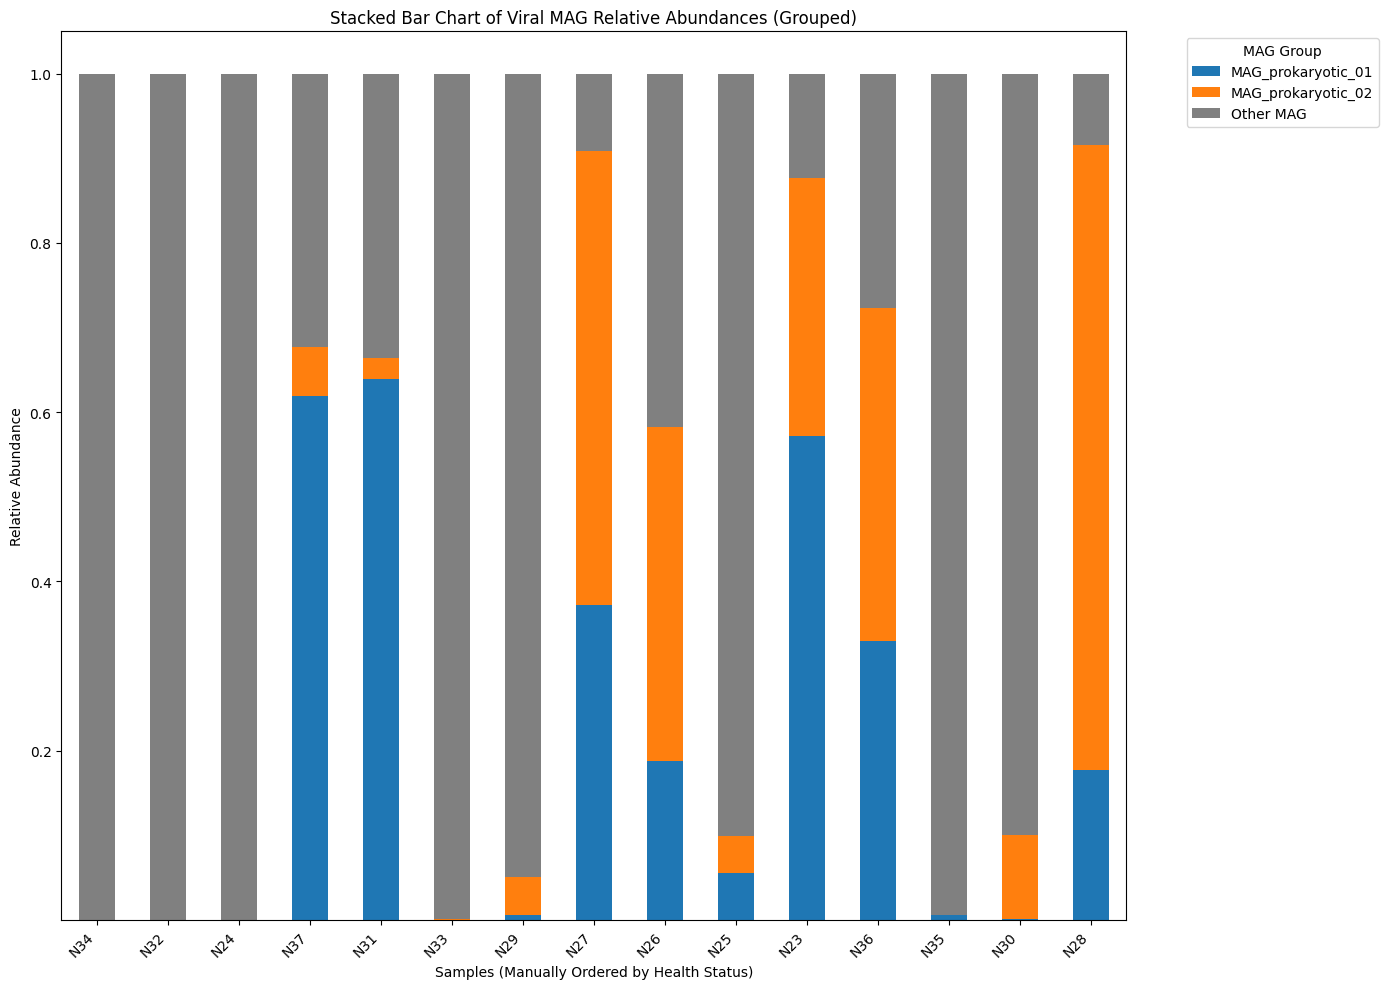

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/read_coverage_streamlined.csv')
df = df.set_index("MAG")

# Filter out unwanted MAGs
df = df.loc[~df.index.str.contains("MAG_viral_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_plasmid_", regex=False), :]
df = df.loc[~df.index.str.contains("MAG_eukaryotic_", regex=False), :]
df = df[df.index != "unmapped"]

# Keep only TPM columns and calculate relative abundance
df = df.filter(like="TPM_")
df_relative = df.div(df.sum(axis=0), axis=1)
df_relative = df_relative.add_prefix('RA_')

# Define target MAGs
target_mags = {"MAG_prokaryotic_01", "MAG_prokaryotic_02"}

# Create MAG_group column
df_relative["MAG_group"] = df_relative.index.map(lambda x: x if x in target_mags else "Other MAG")

# Load taxonomy and merge
#virus_tax = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/viral_mag_taxonomy.csv')
#virus_tax = virus_tax.set_index("MAG")
#df_relative_taxa = pd.merge(df_relative, virus_tax, left_index=True, right_index=True)

# Clean sample names
df_relative_taxa = df_relative
df_relative_taxa.columns = df_relative_taxa.columns.str.replace("RA_TPM_", "", regex=False)

# Manual sample order
manual_order = [ "N34", "N32", "N24","N37","N31",  # Healthy (H)
                 "N33", "N29", "N27", "N26", "N25",  # Diseased (DS)
                 "N23", "N36", "N35", "N30", "N28"]  # AH

# Select numeric data (i.e., sample columns)
numeric_df = df_relative_taxa[manual_order]

# Group by MAG_group
metadata_group = df_relative_taxa["MAG_group"]
grouped_df = numeric_df.groupby(metadata_group).sum()

# Transpose and reorder for plotting
grouped_df = grouped_df.T
grouped_df = grouped_df.loc[manual_order]

# Assign gray to 'Other MAG' and palette to others
unique_groups = grouped_df.columns.tolist()
custom_colors = {"Other MAG": "gray"}
other_mags = [mag for mag in unique_groups if mag != "Other MAG"]
palette = sns.color_palette("tab10", len(other_mags))
for mag, color in zip(other_mags, palette):
    custom_colors[mag] = color
color_list = [custom_colors[mag] for mag in unique_groups]

# Plot
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(14, 10), color=color_list)

# Formatting
plt.xlabel("Samples (Manually Ordered by Health Status)")
plt.ylabel("Relative Abundance")
plt.title("Stacked Bar Chart of Viral MAG Relative Abundances (Grouped)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="MAG Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/Users/Shrini/Desktop/prokaryotic_image_alternate.pdf")
plt.show()


## 7. Rosales et al Comparitive Abundance analysis

In [ ]:
# note this code was run on bash terminal
# mapping reads to reads to MAGs
for file in /scratch/shrinivas/Coral_Projects/03_Dominican_Republic/metastudy/*_1.fastq; do
    # Extract the base name (removing _R1.fastq.gz)
    base=$(basename "$file" _1.fastq)

    # Run Bowtie2 and convert SAM to sorted BAM
    bowtie2 --local -x /scratch/shrinivas/Coral_Projects/03_Dominican_Republic/metastudy/all_MAGs_dr/bowtie_index/all_mags_bowtie2_index -1 "$file" -2 "/scratch/shrinivas/Coral_Projects/03_Dominican_Republic/metastudy/${base}_2.fastq" --threads 60 | \
    /home/timothy/programs/samtools-1.11/samtools view -bS | /home/timothy/programs/samtools-1.11/samtools sort -o "${base}_aligned_sorted.bam"

    # Index the BAM file
    /home/timothy/programs/samtools-1.11/samtools index "${base}_aligned_sorted.bam"
done


coverm genome --bam-files /scratch/shrinivas/Coral_Projects/03_Dominican_Republic/metastudy/all_MAGs_dr/*.bam --genome-fasta-directory /scratch/shrinivas/Coral_Projects/03_Dominican_Republic/metastudy/all_MAGs_dr/genomes/ --methods tpm --output-file all_mags_metastudy.tsv --threads 50

/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y

/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y

/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)
/var/folders/13/dpv2gl8s1yjdgkc0x57hkc100000gp/T/ipykernel_16298/2458918724.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y

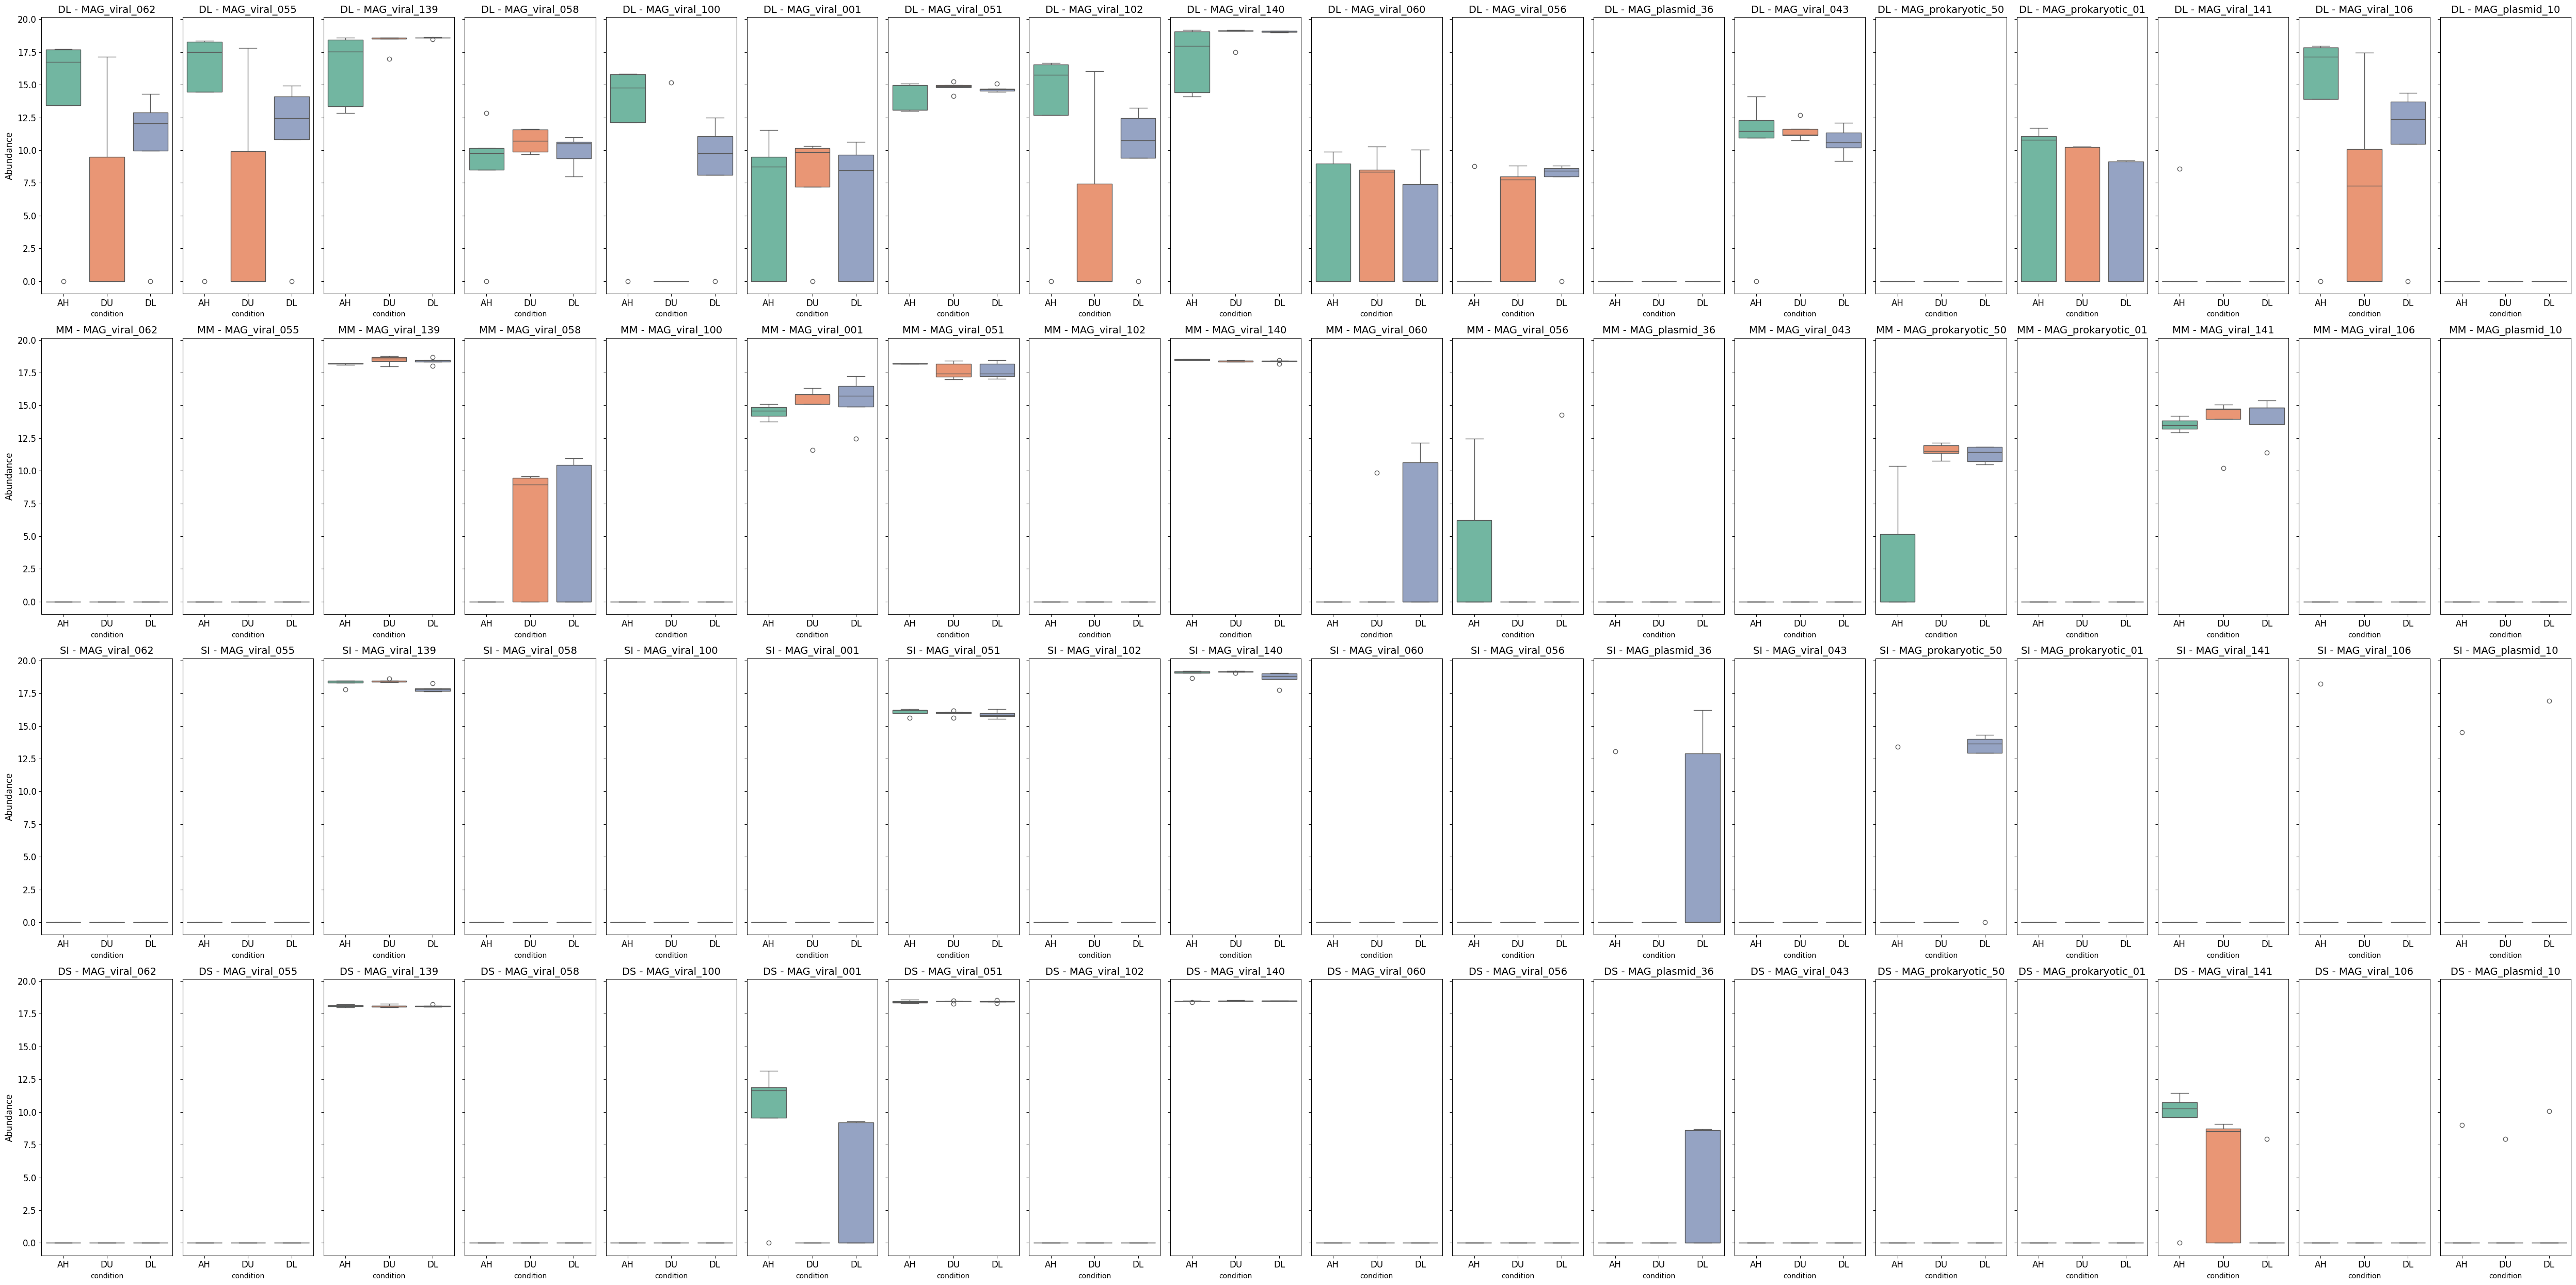

In [9]:

import pandas as pd
counts = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/sctld_rosales/all_mags_metastudy.tsv', sep='\t')
counts.columns = counts.columns.str.replace(r'_aligned_sorted TPM$', '', regex=True)
counts = counts.set_index("Genome")
counts = counts.transpose()
counts = counts.reset_index()
counts = counts.rename(columns={'index': 'Run'})
counts


# load in the metadata
metadata = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/sctld_rosales/metastudy_sctld_sra.csv')
columns_to_keep = ['Run', 'host', 'condition']  # Replace with your actual column names
# Subset the dataframe
metadata = metadata[columns_to_keep]
df = pd.merge(counts, metadata, on="Run")
#df = df.reset_index()
#df = df.transpose()
df

df['host'].unique()
df_transformed = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_transformed[numeric_cols] = np.log2(df_transformed[numeric_cols] + 1)

# Count the number of non-zero values per column
non_zero_counts = (df_transformed.iloc[:, :-1] != 0).sum()  # Excluding the last column if it's categorical

# Select columns with at least 5 non-zero values
columns_to_keep = non_zero_counts[non_zero_counts >= 5].index

# Subset the dataframe
df_filtered = df_transformed[columns_to_keep]

df_filtered

MM = df_transformed[df_transformed['host'] == 'Meandrina_meandrites']
DL = df_transformed[df_transformed['host'] == 'Diploria_labyrinthiformis']
DS = df_transformed[df_transformed['host'] == 'Dichocoenia_stokesii']
SI = df_transformed[df_transformed['host'].isin(['Stephanocoenia_intersepta', 'Stephanocoenia intersepta'])]


import seaborn as sns
import matplotlib.pyplot as plt

# List of datasets and columns of interest
datasets = [DL, MM, SI, DS]  # Replace with your actual datasets
dataset_names = ["DL", "MM", "SI", "DS"]
columns_of_interest = [
    "MAG_viral_062", "MAG_viral_055", "MAG_viral_139", "MAG_viral_058",
    "MAG_viral_100", "MAG_viral_001", "MAG_viral_051", "MAG_viral_102",
    "MAG_viral_140", "MAG_viral_060", "MAG_viral_056", "MAG_plasmid_36",
    "MAG_viral_043", "MAG_prokaryotic_50", "MAG_prokaryotic_01", "MAG_viral_141",
    "MAG_viral_106", "MAG_plasmid_10"
]
x_order = ["AH", "DU", "DL"]  # Custom order for x-axis categories

# Create a figure with larger size for clarity
fig, axes = plt.subplots(len(datasets), len(columns_of_interest), figsize=(50, 25), sharey=True)

# Loop through datasets and columns
for row_idx, (df, dataset_name) in enumerate(zip(datasets, dataset_names)):
    for col_idx, column in enumerate(columns_of_interest):
        ax = axes[row_idx, col_idx]  # Select subplot

        # Box plot with custom x-axis order
        sns.boxplot(x='condition', y=column, data=df, ax=ax, palette="Set2", order=x_order)

        # Customize plot
        ax.set_title(f"{dataset_name} - {column}", fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        if col_idx == 0:
            ax.set_ylabel("Abundance", fontsize=12)
        else:
            ax.set_ylabel("")

# Adjust layout for better spacing
plt.tight_layout()
#plt.savefig("/Users/Shrini/Desktop/alt_all_MAGs.pdf")
plt.show()


In [43]:
counts = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/sctld_rosales/all_mags_metastudy.tsv', sep='\t')
counts.columns = counts.columns.str.replace(r'_aligned_sorted TPM$', '', regex=True)
counts = counts.set_index("Genome")
counts = counts.transpose()
counts = counts.reset_index()
counts = counts.rename(columns={'index': 'Run'})
counts

metadata = pd.read_csv('/Users/Shrini/Desktop/desktop_SCTLD_Complete/sctld_rosales/metastudy_sctld_sra.csv')
columns_to_keep = ['Run', 'host', 'condition']  # Replace with your actual column names
# Subset the dataframe
metadata = metadata[columns_to_keep]
df = pd.merge(counts, metadata, on="Run")
#df = df.reset_index()
#df = df.transpose()
df = df[[col for col in df.columns if "MAG_prokaryotic" in col or "MAG_viral" in col or col in ["run", "host", "condition"]]]


mag_cols = [col for col in df.columns if "MAG_prokaryotic" in col or "MAG_viral" in col]

# Step 2: Create binary presence/absence matrix
df[mag_cols] = (df[mag_cols] > 0).astype(int)

df["host"] = df["host"].replace("Stephanocoenia intersepta", "Stephanocoenia_intersepta")

# Step 3: Group by 'host' and sum across replicates
df_grouped = df.groupby("host")[mag_cols].sum()


df













,MAG_viral_132,MAG_viral_074,MAG_viral_103,MAG_prokaryotic_48,MAG_viral_124,MAG_prokaryotic_61,MAG_prokaryotic_80,MAG_prokaryotic_78,MAG_prokaryotic_09,MAG_viral_137,...,MAG_viral_053,MAG_viral_018,MAG_viral_024,MAG_prokaryotic_59,MAG_viral_079,MAG_viral_021,MAG_prokaryotic_66,MAG_viral_118,host,condition
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Meandrina_meandrites,DL
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Meandrina_meandrites,DU
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Meandrina_meandrites,AH
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Meandrina_meandrites,DL
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Diploria_labyrinthiformis,DL
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Meandrina_meandrites,AH
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Diploria_labyrinthiformis,DU
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Diploria_labyrinthiformis,AH
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Diploria_labyrinthiformis,DL
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Diploria_labyrinthiformis,DU


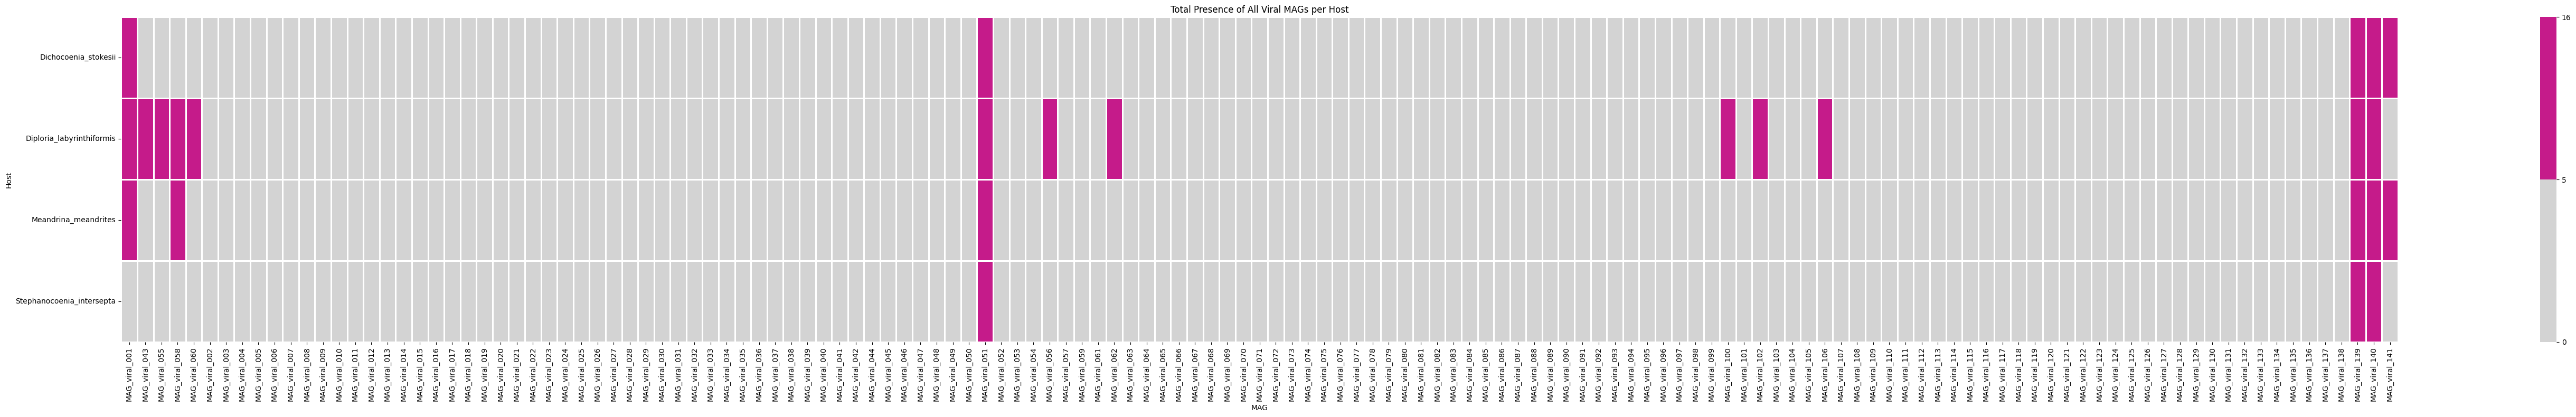

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# --- Step 1: Define selected MAGs ---
selected_mags = ["MAG_viral_001", "MAG_viral_043", "MAG_viral_055", "MAG_viral_058", "MAG_viral_060"]

# --- Step 2: Identify all MAG_viral columns ---
all_viral_mags = [col for col in df_grouped.columns if "MAG_viral" in col]

# --- Step 3: Get remaining MAGs ---
remaining_mags = [col for col in all_viral_mags if col not in selected_mags]

# --- Step 4: Combine selected first, then remaining MAGs ---
ordered_mags = selected_mags + sorted(remaining_mags)

# --- Step 5: Subset df_grouped with ordered MAGs ---
df_final = df_grouped[ordered_mags]

# --- Step 6: Define custom colormap ---
colors = ["lightgrey", "#c51b8a"]  # 0–4 = grey, 5+ = red
bounds = [0, 5, df_final.to_numpy().max() + 1]
norm = mcolors.BoundaryNorm(bounds, len(colors))
cmap = mcolors.ListedColormap(colors)

# --- Step 7: Plot heatmap ---
plt.figure(figsize=(max(2, len(ordered_mags) * 0.4), 8))
sns.heatmap(df_final, cmap=cmap, norm=norm, cbar=True, linewidths=1.0, linecolor='white')
plt.xlabel("MAG")
plt.ylabel("Host")
plt.title("Total Presence of All Viral MAGs per Host")
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("/Users/Shrini/Desktop/viral_rosales_presence_absence.pdf")
plt.show()


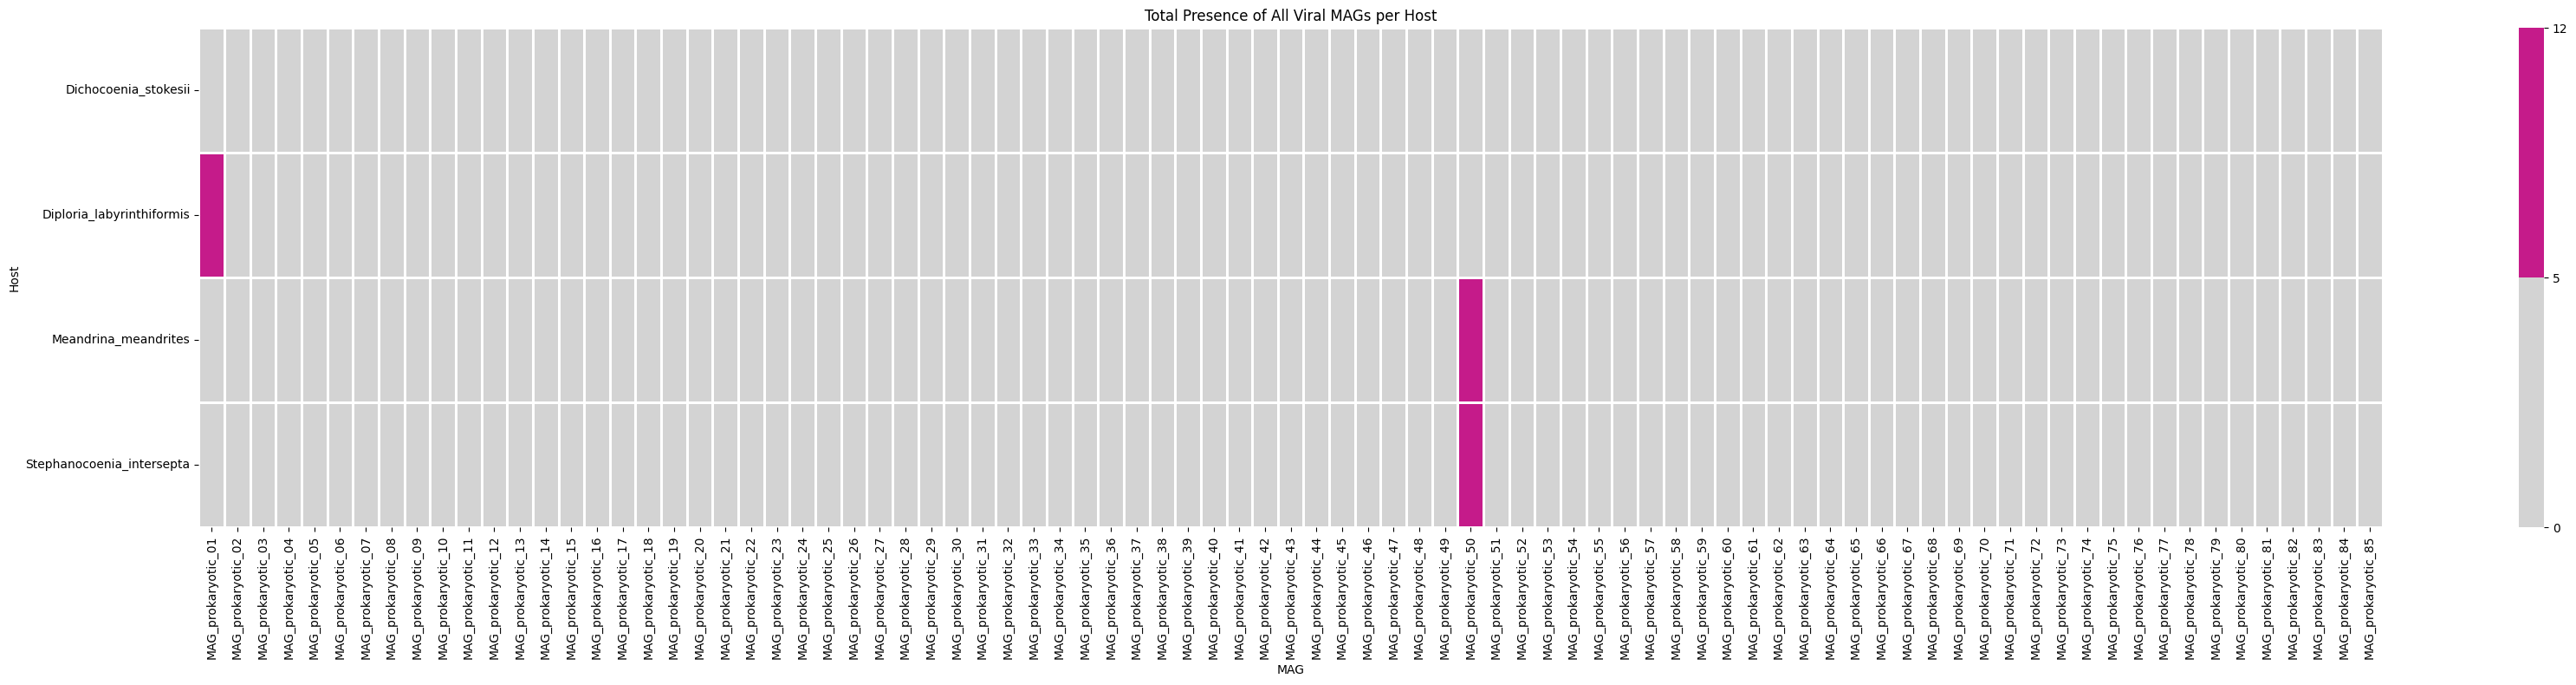

In [52]:
# --- Step 1: Define selected MAGs ---
#selected_mags = ["MAG_viral_001", "MAG_viral_043", "MAG_viral_055", "MAG_viral_058", "MAG_viral_060"]

# --- Step 2: Identify all MAG_viral columns ---
all_prok_mags = [col for col in df_grouped.columns if "MAG_prok" in col]

# --- Step 3: Get remaining MAGs ---
remaining_mags = [col for col in all_prok_mags if col not in selected_mags]

# --- Step 4: Combine selected first, then remaining MAGs ---
ordered_mags = sorted(remaining_mags)

# --- Step 5: Subset df_grouped with ordered MAGs ---
df_final = df_grouped[ordered_mags]

# --- Step 6: Define custom colormap ---
colors = ["lightgrey", "#c51b8a"]  # 0–4 = grey, 5+ = red
bounds = [0, 5, df_final.to_numpy().max() + 1]
norm = mcolors.BoundaryNorm(bounds, len(colors))
cmap = mcolors.ListedColormap(colors)

# --- Step 7: Plot heatmap ---
plt.figure(figsize=(max(14, len(ordered_mags) * 0.4), 8))
sns.heatmap(df_final, cmap=cmap, norm=norm, cbar=True, linewidths=1.0, linecolor='white')
plt.xlabel("MAG")
plt.ylabel("Host")
plt.title("Total Presence of All Viral MAGs per Host")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/Users/Shrini/Desktop/prok_rosales_presence_absence.pdf")

plt.show()